# Final Machine Unlearning Notebook

This notebook contains the complete implementation for machine unlearning experiments.

## Imports

### Import Required Libraries

Import all necessary libraries for:
- **NumPy & Pandas**: Data manipulation and array operations
- **PyTorch**: Neural network framework
- **Matplotlib & Seaborn**: Data visualization
- **Scikit-learn**: Train/test split and evaluation metrics
- **tqdm**: Progress bars for training loops

In [28]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from tqdm import tqdm
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time

### Generate the Spiral Dataset

This cell generates a synthetic multi-class spirals dataset. Here's how it works:

#### Dataset Characteristics:
- **4 classes**: Each representing a different spiral arm
- **300 samples per class**: Total of 1200 data points
- **2D features**: X and Y coordinates in a plane

#### Mathematical Generation Process:

For each class (spiral arm):

1. **Generate theta values**: `theta = sqrt(random) * 2π`
   - Random values are square-rooted to get more uniform distribution along the spiral
   - Multiplied by 2π to create approximately 1 full rotation

2. **Calculate angle offset**: Each spiral is rotated by `(2π * class_index) / 4`
   - Class 0: 0° rotation
   - Class 1: 90° rotation
   - Class 2: 180° rotation
   - Class 3: 270° rotation
   - This spreads the spirals evenly around the origin

3. **Generate spiral radius**: `r = 2 * theta + π`
   - Creates an Archimedean spiral (constant spacing between turns)
   - The radius grows linearly with the angle

4. **Convert to Cartesian coordinates**:
   - `x = cos(theta + angle_offset) * r`
   - `y = sin(theta + angle_offset) * r`
   - This creates the spiral shape in 2D space

5. **Add Gaussian noise**: `data + N(0, 0.5²)`
   - Adds random noise with standard deviation 0.5
   - Makes the classification problem more realistic and challenging
   - Creates some overlap between classes

6. **Shuffle the data**: Randomly reorder all points
   - Ensures no ordering bias during training

#### Why Spirals?
- **Non-linearly separable**: Cannot be separated by straight lines
- **Complex decision boundaries**: Requires neural networks to learn curved boundaries
- **Ideal for testing**: Perfect for evaluating machine learning and unlearning algorithms
- **Visually interpretable**: Easy to visualize and understand the results

The generated data is stored in the `res` variable as a numpy array with shape (1200, 3), where:
- Column 0: X coordinate
- Column 1: Y coordinate
- Column 2: Class label (0, 1, 2, or 3)

In [29]:
# Set random seed for reproducibility, always 42!!
rng = np.random.default_rng(42)
torch.manual_seed(42)

# Generate multi-class spirals dataset
N = 300  # Samples per class
num_classes = 4  # Number of spiral classes

all_data = []

for class_idx in range(num_classes):
    # Generate theta values
    theta = np.sqrt(rng.random(N)) * 2 * pi
    
    # Calculate the angle offset for this spiral
    angle_offset = (2 * pi * class_idx) / num_classes
    
    # Generate spiral with rotation
    r = 2 * theta + pi
    
    # Apply rotation to spread spirals evenly
    x = np.cos(theta + angle_offset) * r
    y = np.sin(theta + angle_offset) * r
    
    # Stack coordinates
    data = np.array([x, y]).T
    
    # Add noise using modern generator API
    data = data + rng.standard_normal((N, 2)) * 0.5
    
    # Add labels
    labeled_data = np.append(data, np.full((N, 1), class_idx), axis=1)
    all_data.append(labeled_data)

# Combine all classes
res = np.vstack(all_data)
rng.shuffle(res)  # Use generator's shuffle method

print(f"Dataset shape: {res.shape}")
print(f"Total samples: {len(res)}")
print(f"Number of classes: {num_classes}")
for i in range(num_classes):
    print(f"Class {i} samples: {np.sum(res[:, 2] == i)}")

Dataset shape: (1200, 3)
Total samples: 1200
Number of classes: 4
Class 0 samples: 300
Class 1 samples: 300
Class 2 samples: 300
Class 3 samples: 300


### Visualize the Generated Dataset

Display the complete spiral dataset immediately after generation:
- Shows all 1200 points
- Each class in a different color
- Demonstrates the non-linear, complex decision boundaries

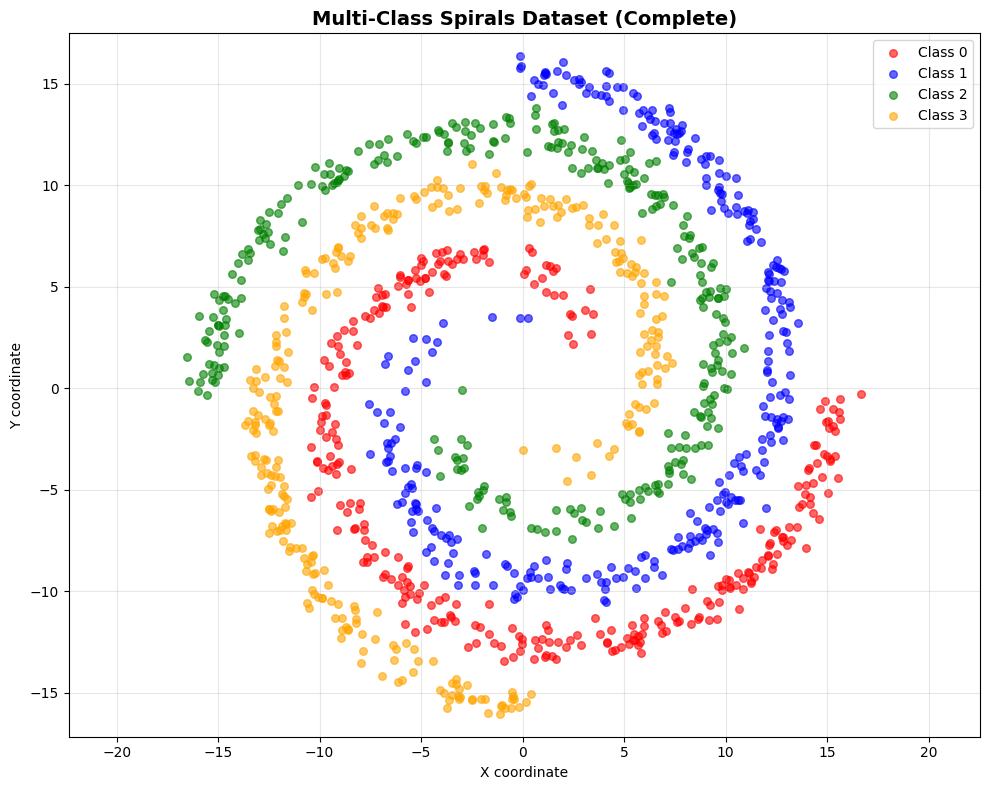

In [30]:
# Visualize the complete dataset
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'orange']

for class_idx in range(num_classes):
    class_data = res[res[:, 2] == class_idx]
    plt.scatter(class_data[:, 0], class_data[:, 1], 
                c=colors[class_idx], label=f'Class {class_idx}',
                alpha=0.6, s=30)

plt.title('Multi-Class Spirals Dataset (Complete)', fontsize=14, fontweight='bold')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

## Data Preparation for Training

### Load and Inspect the Dataset

This cell takes the generated spiral dataset and prepares it for training:
- Extracts features (X) and labels (y)
- Determines the number of classes
- Displays dataset information including shapes and feature ranges

In [31]:
# Use the generated spiral dataset from the previous cell
data = res

# Extract features and labels
X = data[:, :2]  # Features (x, y coordinates)
y = data[:, 2]   # Labels (class)

# Get number of classes
num_classes = int(y.max() + 1)

print(f"Dataset information:")
print(f"  Features shape: {X.shape}")
print(f"  Labels shape: {y.shape}")
print(f"  Number of classes: {num_classes}")
print(f"  Feature range - X: [{X[:, 0].min():.2f}, {X[:, 0].max():.2f}], Y: [{X[:, 1].min():.2f}, {X[:, 1].max():.2f}]")

Dataset information:
  Features shape: (1200, 2)
  Labels shape: (1200,)
  Number of classes: 4
  Feature range - X: [-16.52, 16.68], Y: [-16.07, 16.38]


### Split Data into Training and Test Sets

Split the dataset using an 80-20 ratio:
- **80% for training**: Used to train the neural network
- **20% for testing**: Used to evaluate model performance
- Uses stratified split to maintain class distribution in both sets

In [32]:
# Split the data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Ensures equal class distribution in train and test
)

print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"\nClass distribution in training set:")
for i in range(num_classes):
    count = np.sum(y_train == i)
    print(f"  Class {i}: {count} samples ({count/len(y_train)*100:.1f}%)")
print(f"\nClass distribution in test set:")
for i in range(num_classes):
    count = np.sum(y_test == i)
    print(f"  Class {i}: {count} samples ({count/len(y_test)*100:.1f}%)")

Training set size: 960 samples
Test set size: 240 samples

Class distribution in training set:
  Class 0: 240 samples (25.0%)
  Class 1: 240 samples (25.0%)
  Class 2: 240 samples (25.0%)
  Class 3: 240 samples (25.0%)

Class distribution in test set:
  Class 0: 60 samples (25.0%)
  Class 1: 60 samples (25.0%)
  Class 2: 60 samples (25.0%)
  Class 3: 60 samples (25.0%)


### Visualize Train/Test Split

Create a visualization showing the data split:
- Training data points (larger, filled markers)
- Test data points (smaller markers with borders)
- Different colors for each class
- Helps verify the split maintains the spiral structure

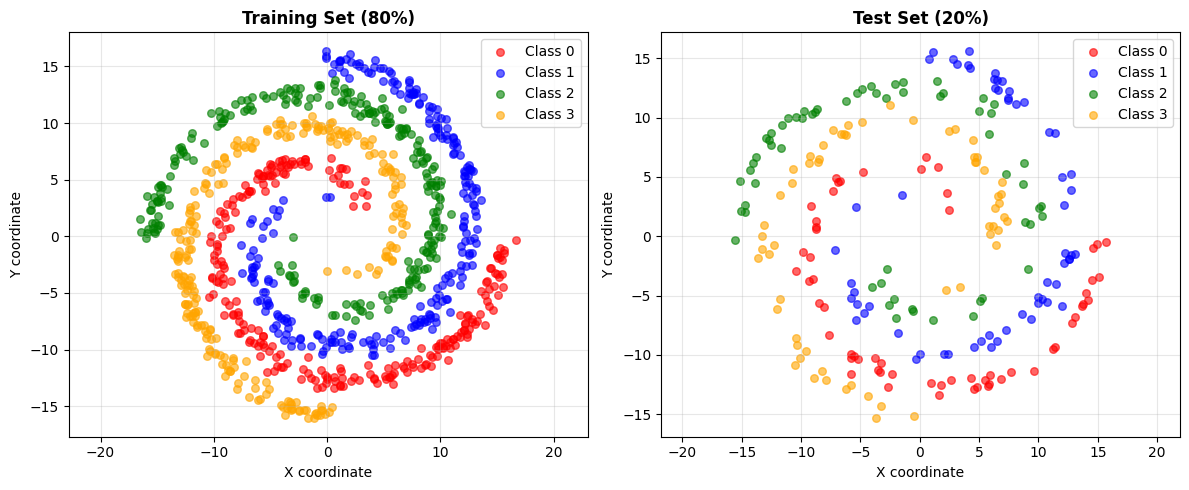

Training samples: 960
Test samples: 240


In [33]:
# Visualize the train/test split
plt.figure(figsize=(12, 5))
colors = ['red', 'blue', 'green', 'orange']

# Plot 1: Training data
plt.subplot(1, 2, 1)
for class_idx in range(num_classes):
    class_mask = y_train == class_idx
    plt.scatter(X_train[class_mask, 0], X_train[class_mask, 1],
                c=colors[class_idx], label=f'Class {class_idx}',
                alpha=0.6, s=30)
plt.title('Training Set (80%)', fontsize=12, fontweight='bold')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Plot 2: Test data
plt.subplot(1, 2, 2)
for class_idx in range(num_classes):
    class_mask = y_test == class_idx
    plt.scatter(X_test[class_mask, 0], X_test[class_mask, 1],
                c=colors[class_idx], label=f'Class {class_idx}',
                alpha=0.6, s=30)
plt.title('Test Set (20%)', fontsize=12, fontweight='bold')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.tight_layout()
plt.show()

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

### Standardize the Features

Normalize the features to have zero mean and unit variance:
- Improves neural network training convergence
- Prevents features with larger scales from dominating
- Uses training set statistics to transform both train and test sets

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize features (zero mean, unit variance)
# This is crucial for neural networks because:
# 1. Features on different scales can cause training instability
# 2. Gradient descent converges faster with normalized inputs
# 3. Prevents larger-valued features from dominating the learning process

# IMPORTANT: We fit the scaler ONLY on training data to prevent data leakage
# If we used the full dataset, information from the test set would leak into training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test_scaled = scaler.transform(X_test)        # Only transform test (using train statistics)

print(f"Training data statistics (before scaling):")
print(f"  Mean: {X_train.mean(axis=0)}")
print(f"  Std: {X_train.std(axis=0)}")

print(f"\nAfter scaling:")
print(f"  Train mean: {X_train_scaled.mean(axis=0)}")  # Should be ~0
print(f"  Train std: {X_train_scaled.std(axis=0)}")    # Should be ~1
print(f"  Test mean: {X_test_scaled.mean(axis=0)}")    # Close to 0 (but not exactly)
print(f"  Test std: {X_test_scaled.std(axis=0)}")      # Close to 1 (but not exactly)

# Save the scaler object for later use in machine unlearning experiments
# We'll need it to transform forget sets using the same scaling parameters
print(f"\n✓ StandardScaler object created and fitted (will be reused later)")

Training data statistics:
  Mean: [ 0.26551216 -0.08844693]
  Std: [8.38323429 8.3297269 ]

After scaling:
  Train mean: [5.97901358e-17 1.64220489e-17]
  Train std: [1. 1.]
  Test mean: [-0.03155592  0.04156343]
  Test std: [0.9969339  1.01151222]


### Visualize Normalized Data

Display the standardized (normalized) dataset:
- Shows how the data looks after standardization
- Features now have zero mean and unit variance
- The shape and relationships are preserved, just rescaled
- This is what the neural network will actually see during training

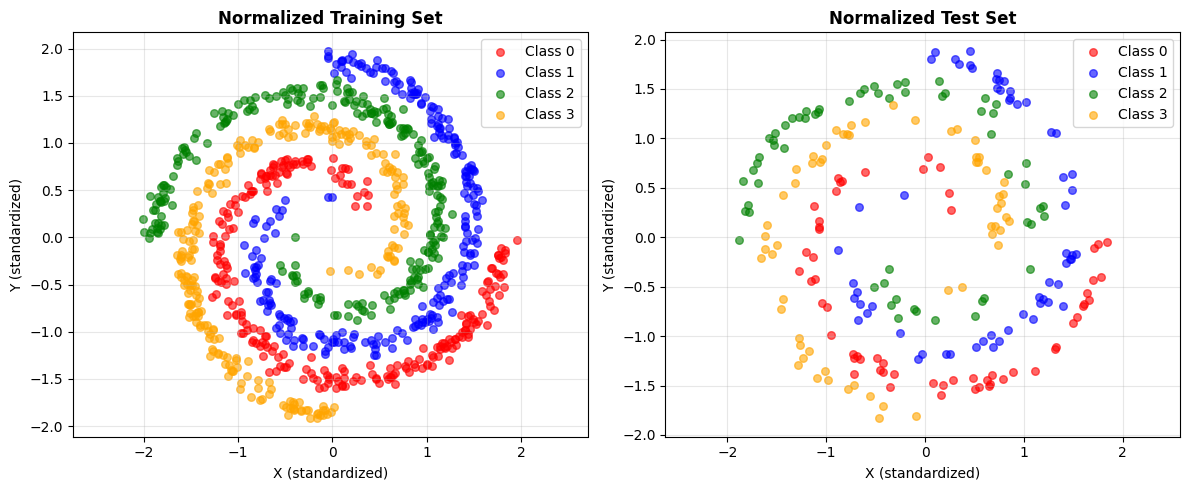

Training set - Mean: [0.000000, 0.000000]
Training set - Std: [1.000000, 1.000000]


In [35]:
# Visualize the normalized data
plt.figure(figsize=(12, 5))
colors = ['red', 'blue', 'green', 'orange']

# Plot 1: Normalized training data
plt.subplot(1, 2, 1)
for class_idx in range(num_classes):
    class_mask = y_train == class_idx
    plt.scatter(X_train_scaled[class_mask, 0], X_train_scaled[class_mask, 1],
                c=colors[class_idx], label=f'Class {class_idx}',
                alpha=0.6, s=30)
plt.title('Normalized Training Set', fontsize=12, fontweight='bold')
plt.xlabel('X (standardized)')
plt.ylabel('Y (standardized)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Plot 2: Normalized test data
plt.subplot(1, 2, 2)
for class_idx in range(num_classes):
    class_mask = y_test == class_idx
    plt.scatter(X_test_scaled[class_mask, 0], X_test_scaled[class_mask, 1],
                c=colors[class_idx], label=f'Class {class_idx}',
                alpha=0.6, s=30)
plt.title('Normalized Test Set', fontsize=12, fontweight='bold')
plt.xlabel('X (standardized)')
plt.ylabel('Y (standardized)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.tight_layout()
plt.show()

print(f"Training set - Mean: [{X_train_scaled[:, 0].mean():.6f}, {X_train_scaled[:, 1].mean():.6f}]")
print(f"Training set - Std: [{X_train_scaled[:, 0].std():.6f}, {X_train_scaled[:, 1].std():.6f}]")

### Convert to PyTorch Tensors

Convert numpy arrays to PyTorch tensors:
- Features are converted to `float32` tensors
- Labels are converted to `long` (int64) tensors for classification
- Required format for PyTorch neural network training

In [36]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.LongTensor(y_train.astype(int))
y_test_tensor = torch.LongTensor(y_test.astype(int))

print(f"Tensor shapes:")
print(f"  X_train: {X_train_tensor.shape}, dtype: {X_train_tensor.dtype}")
print(f"  X_test: {X_test_tensor.shape}, dtype: {X_test_tensor.dtype}")
print(f"  y_train: {y_train_tensor.shape}, dtype: {y_train_tensor.dtype}")
print(f"  y_test: {y_test_tensor.shape}, dtype: {y_test_tensor.dtype}")

Tensor shapes:
  X_train: torch.Size([960, 2]), dtype: torch.float32
  X_test: torch.Size([240, 2]), dtype: torch.float32
  y_train: torch.Size([960]), dtype: torch.int64
  y_test: torch.Size([240]), dtype: torch.int64


### Create PyTorch Datasets

Wrap tensors in `TensorDataset` objects:
- Combines features and labels into a single dataset
- Enables easy batching and shuffling during training
- Separate datasets for training and testing

In [37]:
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for batch processing
batch_size = 32

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,  # Shuffle training data
    drop_last=False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # Don't shuffle test data
    drop_last=False
)

print(f"DataLoader configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Number of training batches: {len(train_loader)}")
print(f"  Number of test batches: {len(test_loader)}")
print(f"\nData is ready for model training!")

DataLoader configuration:
  Batch size: 32
  Number of training batches: 30
  Number of test batches: 8

Data is ready for model training!


## TabNet Model Implementation

TabNet is a state-of-the-art deep learning architecture specifically designed for tabular data. It combines the power of neural networks with interpretability features.

### What is TabNet?

**TabNet** (Tabular Network) is a novel deep learning architecture introduced by Google Research in 2019, specifically designed for tabular data.

#### Key Features:

1. **Attention-Based Feature Selection**
   - Uses sequential attention mechanism to select relevant features at each decision step
   - Learns which features are important for each prediction
   - Mimics decision trees but in a differentiable way

2. **Instance-Wise Feature Selection**
   - Different features can be important for different samples
   - Provides sample-specific feature importance
   - Unlike traditional models that use the same features for all predictions

3. **Interpretability**
   - Built-in feature importance scores
   - Attention masks show which features were used for each prediction
   - Helps understand model decisions (crucial for machine unlearning)

4. **Self-Supervised Learning**
   - Can use unsupervised pre-training on unlabeled data
   - Improves performance when labeled data is limited

5. **Sparse Feature Selection**
   - Uses sparsemax instead of softmax for attention
   - Promotes sparse solutions (only a few features selected per step)
   - Reduces overfitting and improves efficiency

#### Architecture Components:

- **Feature Transformer**: Processes selected features through shared and decision-step-specific layers
- **Attentive Transformer**: Generates attention masks for feature selection
- **Decision Steps**: Multiple sequential steps that iteratively refine the prediction
- **Ghost Batch Normalization**: Stabilizes training with small batch sizes

#### Why TabNet for This Task?

1. **Tabular Data Excellence**: Our spiral dataset is tabular (X, Y coordinates)
2. **Interpretability**: Essential for understanding what features the model learns
3. **Non-linear Boundaries**: Can learn complex spiral patterns
4. **Feature Importance**: Helps identify what the model focuses on
5. **Machine Unlearning**: Interpretability aids in selective forgetting

#### TabNet vs Traditional Models:

| Aspect | TabNet | Traditional NN | Decision Trees |
|--------|--------|----------------|----------------|
| Interpretability | ✅ High | ❌ Low | ✅ High |
| Feature Selection | ✅ Automatic | ❌ Manual | ✅ Automatic |
| Tabular Data | ✅ Optimized | ⚠️ Requires tuning | ✅ Native |
| Non-linear | ✅ Yes | ✅ Yes | ⚠️ Limited |
| Scalability | ✅ Good | ✅ Excellent | ⚠️ Limited |

### Define TabNet Model Configuration

Configure the TabNet model with specific hyperparameters.

#### Key Hyperparameters Explained:

- **n_d, n_a** (8): Width of decision and attention layers
  - Controls model capacity
  - Typical range: 8-64
  - Higher = more capacity but slower training

- **n_steps** (3): Number of sequential attention steps
  - How many times the model refines its prediction
  - Range: 3-10
  - More steps = more interpretable but slower

- **gamma** (1.3): Coefficient for feature reuse penalty
  - Encourages using different features at each step
  - Range: 1.0-2.0
  - Higher = more feature diversity

- **lambda_sparse** (1e-3): Sparsity regularization
  - Encourages sparse attention (fewer features per step)
  - Improves interpretability

- **optimizer_params**: Learning rate and other optimizer settings
- **scheduler_params**: Learning rate decay schedule
- **mask_type** ('sparsemax'): Attention mechanism type
  - 'sparsemax': Sparse attention (recommended)
  - 'entmax': Adaptive sparse attention

In [38]:
# Define TabNet model
tabnet_model = TabNetClassifier(
    n_d=8,                    # Width of the decision prediction layer
    n_a=8,                    # Width of the attention embedding
    n_steps=3,                # Number of sequential decision steps
    gamma=1.3,                # Coefficient for feature reuse in attention
    cat_idxs=[],              # Indices of categorical features (none in our case)
    cat_dims=[],              # Dimensions of categorical features
    cat_emb_dim=1,            # Embedding dimension for categorical features
    n_independent=2,          # Number of independent GLU layers at each step
    n_shared=2,               # Number of shared GLU layers at each step
    epsilon=1e-15,            # Small value to avoid log(0)
    momentum=0.02,            # Momentum for batch normalization
    lambda_sparse=1e-3,       # Sparsity regularization parameter
    seed=42,                  # Random seed for reproducibility
    clip_value=1.0,           # Gradient clipping value
    verbose=1,                # Verbosity level
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params=dict(step_size=10, gamma=0.9),
    mask_type='sparsemax'     # Type of attention mechanism
)

print("TabNet model initialized successfully!")
print(f"Model architecture: {tabnet_model}")

TabNet model initialized successfully!
Model architecture: TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=42, clip_value=1.0, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 10, 'gamma': 0.9}, mask_type='sparsemax', input_dim=None, output_dim=None, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])


/Users/eshaanmittal/Desktop/UB/TFG/Codes/venv/lib/python3.13/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


### Train TabNet Model

Train the TabNet model on the training data.

#### Training Parameters:

- **X_train, y_train**: Training features and labels
- **eval_set**: Validation set to monitor performance during training
- **eval_metric**: Metrics to track ('accuracy' in our case)
- **max_epochs** (200): Maximum number of training epochs
- **patience** (15): Early stopping patience (stops if no improvement)
- **batch_size** (256): Number of samples per batch
- **virtual_batch_size** (128): For Ghost Batch Normalization
- **num_workers** (0): Number of parallel data loading workers
- **drop_last** (False): Whether to drop the last incomplete batch

#### What Happens During Training:

1. **Forward Pass**: Data flows through attention steps
2. **Feature Selection**: Attention masks select relevant features
3. **Prediction**: Combined information makes final prediction
4. **Loss Calculation**: Cross-entropy loss for classification
5. **Backward Pass**: Gradients computed and parameters updated
6. **Validation**: Model evaluated on validation set
7. **Early Stopping**: Training stops if validation doesn't improve

The model will display training progress including loss and accuracy.

In [39]:
# Train the model
print("Starting TabNet training...")
print("=" * 60)

start_time = time.time()

tabnet_model.fit(
    X_train=X_train_scaled,
    y_train=y_train,
    eval_set=[(X_test_scaled, y_test)],
    eval_name=['test'],
    eval_metric=['accuracy'],
    max_epochs=200,
    patience=15,              # Early stopping patience
    batch_size=256,
    virtual_batch_size=128,   # For Ghost Batch Normalization
    num_workers=0,
    drop_last=False
)

training_time = time.time() - start_time

print("=" * 60)
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print("Model trained successfully!")

Starting TabNet training...
epoch 0  | loss: 1.35532 | test_accuracy: 0.25833 |  0:00:00s
epoch 1  | loss: 1.0457  | test_accuracy: 0.38333 |  0:00:00s
epoch 2  | loss: 0.90004 | test_accuracy: 0.39167 |  0:00:00s
epoch 3  | loss: 0.81021 | test_accuracy: 0.40417 |  0:00:00s
epoch 4  | loss: 0.686   | test_accuracy: 0.42917 |  0:00:00s
epoch 5  | loss: 0.6257  | test_accuracy: 0.45417 |  0:00:00s
epoch 6  | loss: 0.57163 | test_accuracy: 0.525   |  0:00:00s
epoch 7  | loss: 0.53204 | test_accuracy: 0.50833 |  0:00:00s
epoch 8  | loss: 0.42188 | test_accuracy: 0.45833 |  0:00:00s
epoch 9  | loss: 0.38194 | test_accuracy: 0.56667 |  0:00:00s
epoch 10 | loss: 0.44068 | test_accuracy: 0.53333 |  0:00:00s
epoch 11 | loss: 0.33996 | test_accuracy: 0.67083 |  0:00:00s
epoch 12 | loss: 0.27684 | test_accuracy: 0.69167 |  0:00:00s
epoch 13 | loss: 0.28157 | test_accuracy: 0.6875  |  0:00:00s
epoch 14 | loss: 0.30733 | test_accuracy: 0.7875  |  0:00:00s
epoch 15 | loss: 0.26255 | test_accuracy: 

/Users/eshaanmittal/Desktop/UB/TFG/Codes/venv/lib/python3.13/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


### Evaluate TabNet Model Performance

Evaluate the trained model on both training and test sets.

#### Evaluation Metrics:

1. **Accuracy**: Percentage of correct predictions
2. **Confusion Matrix**: Shows true vs predicted classes
3. **Classification Report**: Precision, recall, F1-score per class
4. **Training vs Test Performance**: Checks for overfitting

#### What to Look For:

- **High accuracy**: Model learned the patterns well
- **Similar train/test accuracy**: No overfitting
- **Balanced per-class performance**: All spirals classified equally well
- **Diagonal confusion matrix**: Correct predictions on diagonal

In [40]:
# Make predictions
y_train_pred = tabnet_model.predict(X_train_scaled)
y_test_pred = tabnet_model.predict(X_test_scaled)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("=" * 60)
print("TABNET MODEL PERFORMANCE")
print("=" * 60)
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy:     {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Overfitting Gap:   {abs(train_accuracy - test_accuracy):.4f}")
print("=" * 60)

# Confusion Matrix
print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, 
                          target_names=[f'Class {i}' for i in range(num_classes)]))

TABNET MODEL PERFORMANCE
Training Accuracy: 0.9885 (98.85%)
Test Accuracy:     0.9833 (98.33%)
Overfitting Gap:   0.0052

Confusion Matrix (Test Set):
[[59  0  0  1]
 [ 1 59  0  0]
 [ 0  0 59  1]
 [ 0  0  1 59]]

Classification Report (Test Set):
              precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98        60
     Class 1       1.00      0.98      0.99        60
     Class 2       0.98      0.98      0.98        60
     Class 3       0.97      0.98      0.98        60

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240



### Visualize TabNet Predictions

Visualize the model's predictions on the test set to see how well it learned the spiral patterns.

The visualization shows:
- **Left plot**: True labels (ground truth)
- **Right plot**: Predicted labels
- **Colors**: Each class has a distinct color

A good model should have very similar-looking plots, indicating accurate predictions.

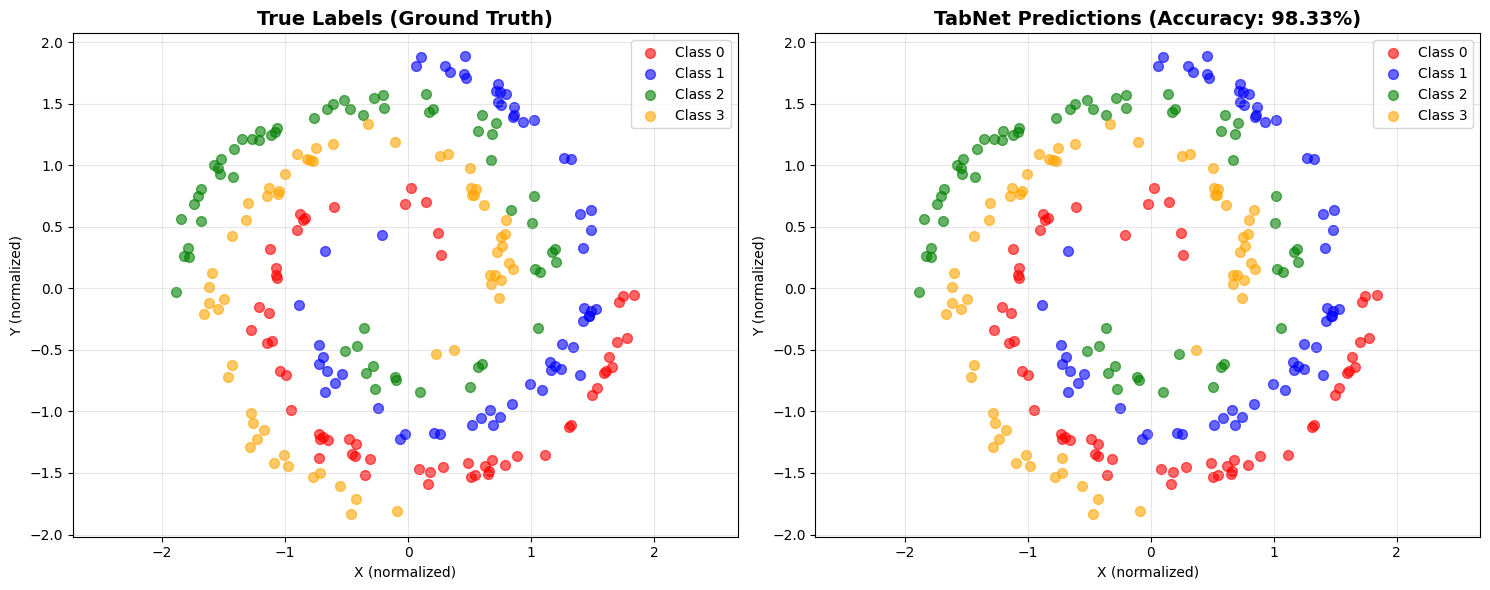


Number of misclassified samples: 4 out of 240
Misclassification rate: 1.67%


In [41]:
# Visualize predictions on test set
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
colors = ['red', 'blue', 'green', 'orange']

# Plot 1: True labels
for class_idx in range(num_classes):
    mask = y_test == class_idx
    axes[0].scatter(X_test_scaled[mask, 0], X_test_scaled[mask, 1],
                   c=colors[class_idx], label=f'Class {class_idx}',
                   alpha=0.6, s=50)
axes[0].set_title('True Labels (Ground Truth)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('X (normalized)')
axes[0].set_ylabel('Y (normalized)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axis('equal')

# Plot 2: Predicted labels
for class_idx in range(num_classes):
    mask = y_test_pred == class_idx
    axes[1].scatter(X_test_scaled[mask, 0], X_test_scaled[mask, 1],
                   c=colors[class_idx], label=f'Class {class_idx}',
                   alpha=0.6, s=50)
axes[1].set_title(f'TabNet Predictions (Accuracy: {test_accuracy:.2%})', 
                 fontsize=14, fontweight='bold')
axes[1].set_xlabel('X (normalized)')
axes[1].set_ylabel('Y (normalized)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')

plt.tight_layout()
plt.show()

# Highlight misclassified points
misclassified = y_test != y_test_pred
print(f"\nNumber of misclassified samples: {misclassified.sum()} out of {len(y_test)}")
print(f"Misclassification rate: {misclassified.sum()/len(y_test)*100:.2f}%")

### TabNet Feature Importance

One of TabNet's key advantages is built-in feature importance!

#### What is Feature Importance?

Feature importance shows how much each feature (X and Y coordinates) contributed to the model's predictions.

#### How TabNet Computes It:

- Aggregates attention masks across all samples and decision steps
- Higher values = feature was selected more often
- Values sum to 1.0 (normalized)

#### For Our Spiral Dataset:

- Both X and Y coordinates should be important
- If balanced (~0.5 each), both features are equally used
- Helps understand what the model learned
- Crucial for machine unlearning (know what to forget)

FEATURE IMPORTANCE
X coordinate   : 0.4824 (48.24%)
Y coordinate   : 0.5176 (51.76%)


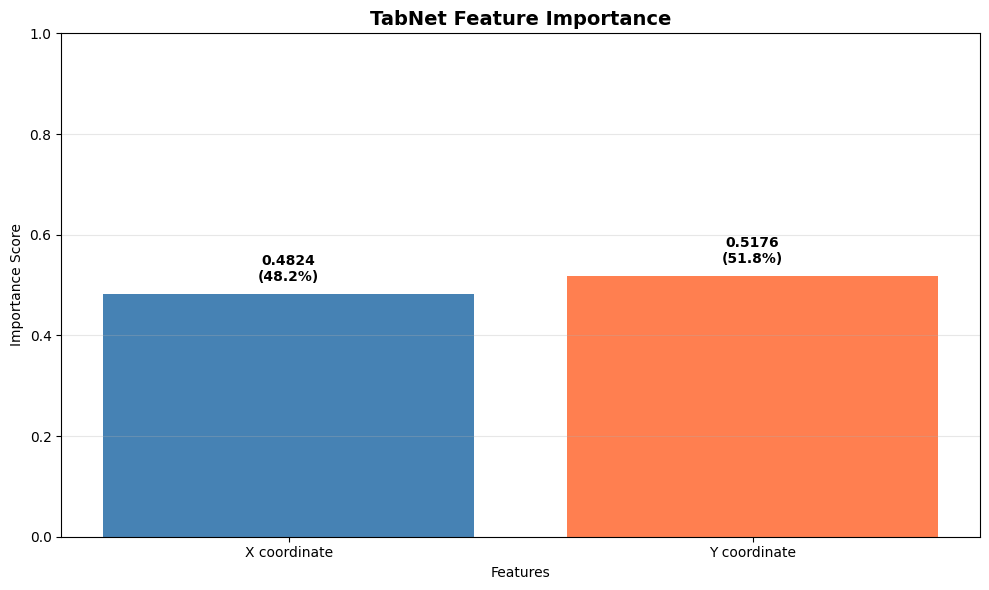


Interpretation:
Both features are equally important (balanced importance).
This makes sense for spiral patterns that use both X and Y symmetrically.


In [42]:
# Get feature importances
feature_importances = tabnet_model.feature_importances_

print("=" * 60)
print("FEATURE IMPORTANCE")
print("=" * 60)
feature_names = ['X coordinate', 'Y coordinate']
for name, importance in zip(feature_names, feature_importances):
    print(f"{name:15s}: {importance:.4f} ({importance*100:.2f}%)")
print("=" * 60)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importances, color=['steelblue', 'coral'])
plt.title('TabNet Feature Importance', fontsize=14, fontweight='bold')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.ylim(0, 1.0)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (name, importance) in enumerate(zip(feature_names, feature_importances)):
    plt.text(i, importance + 0.02, f'{importance:.4f}\n({importance*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
if abs(feature_importances[0] - feature_importances[1]) < 0.1:
    print("Both features are equally important (balanced importance).")
    print("This makes sense for spiral patterns that use both X and Y symmetrically.")
else:
    dominant_feature = feature_names[feature_importances.argmax()]
    print(f"{dominant_feature} is more important for the predictions.")
    print("This suggests the model relies more on one coordinate than the other.")

### Save TabNet Model

Save the trained model for:
- Later use without retraining
- Machine unlearning experiments
- Deployment

The model is saved as a compressed zip file containing:
- Model weights
- Architecture configuration
- Training history

In [43]:
# Save the model
#model_path = 'tabnet_spiral_model'
#tabnet_model.save_model(model_path)
#print(f"Model saved to: {model_path}")
#print("\nTo load the model later, use:")
#print("loaded_model = TabNetClassifier()")
#print(f"loaded_model.load_model('{model_path}')")

## Machine Unlearning: Forget Requests

This section implements three types of forget requests to simulate different unlearning scenarios.
We'll visualize the training set after each type of data removal.

### Understanding Forget Requests

In machine unlearning, we need to handle different types of data removal requests:

#### 1. **Class Removal (Complete Forgetting)**
   - Remove all samples from a specific class
   - Use case: User category completely withdrawn from service
   - Example: Remove all Class 2 spiral samples

#### 2. **Partial Class Removal (Outlier Forgetting)**
   - Remove outer portions of a single class
   - Use case: Remove outliers or edge cases from one category
   - Example: Remove outer 40% of Class 1 samples (by radius)

#### 3. **Multi-Class Partial Removal (Selective Forgetting)**
   - Remove outer portions from multiple classes
   - Use case: Remove edge cases across multiple categories
   - Example: Remove outer 40% of Class 0 and Class 3 samples

#### Why These Scenarios?

- **Realistic Privacy Requests**: Users may want to remove specific data points
- **Test Robustness**: See how model performs with different data removal patterns
- **Evaluate Impact**: Understand which removals affect accuracy most
- **Complexity Levels**: From simple (remove class) to complex (selective removal)

### Helper Functions for Data Removal

These functions implement the logic for different forget request types.

In [44]:
def calculate_radius(X):
    """Calculate Euclidean distance from origin for each point."""
    return np.sqrt(X[:, 0]**2 + X[:, 1]**2)

def remove_entire_class(X_train, y_train, class_to_remove):
    """Remove all samples from a specific class."""
    mask = y_train != class_to_remove
    X_remaining = X_train[mask]
    y_remaining = y_train[mask]
    
    removed_count = np.sum(~mask)
    print(f"Removed {removed_count} samples from Class {class_to_remove}")
    print(f"Remaining samples: {len(y_remaining)}")
    
    return X_remaining, y_remaining, mask

def remove_outer_section(X_train, y_train, class_id, percentile=70):
    """Remove outer section of a specific class based on radius."""
    # Get indices for the specific class
    class_mask = y_train == class_id
    class_indices = np.where(class_mask)[0]
    
    # Calculate radii for this class
    class_X = X_train[class_mask]
    radii = calculate_radius(class_X)
    
    # Find threshold radius (keep inner percentile%)
    threshold = np.percentile(radii, percentile)
    
    # Create mask for points to keep
    keep_mask = radii <= threshold
    
    # Create full dataset mask
    full_mask = np.ones(len(y_train), dtype=bool)
    full_mask[class_indices] = keep_mask
    
    X_remaining = X_train[full_mask]
    y_remaining = y_train[full_mask]
    
    removed_count = np.sum(~keep_mask)
    print(f"Removed {removed_count} outer samples from Class {class_id} (outer {100-percentile}%)")
    print(f"Remaining samples in Class {class_id}: {np.sum(keep_mask)}")
    print(f"Total remaining samples: {len(y_remaining)}")
    
    return X_remaining, y_remaining, full_mask

def remove_outer_sections_multiple(X_train, y_train, class_ids, percentile=70):
    """Remove outer sections from multiple classes."""
    full_mask = np.ones(len(y_train), dtype=bool)
    
    for class_id in class_ids:
        # Get indices for this class
        class_mask = y_train == class_id
        class_indices = np.where(class_mask)[0]
        
        # Calculate radii for this class
        class_X = X_train[class_mask]
        radii = calculate_radius(class_X)
        
        # Find threshold radius
        threshold = np.percentile(radii, percentile)
        
        # Update mask for points to keep
        keep_mask = radii <= threshold
        full_mask[class_indices] = keep_mask
        
        removed_count = np.sum(~keep_mask)
        print(f"Removed {removed_count} outer samples from Class {class_id} (outer {100-percentile}%)")
    
    X_remaining = X_train[full_mask]
    y_remaining = y_train[full_mask]
    
    print(f"\nTotal remaining samples: {len(y_remaining)}")
    
    return X_remaining, y_remaining, full_mask

print("Helper functions defined successfully!")

Helper functions defined successfully!


### Forget Request 1: Remove Entire Class

**Scenario**: Complete removal of Class 2 from the training set.

**Impact**:
- Removes ~240 samples (25% of training data)
- Model will no longer be able to predict Class 2
- Other classes remain intact

**Real-world analogy**: A company stops offering a product category entirely.

In [45]:
# Forget Request 1: Remove entire class (Class 2)
print("=" * 60)
print("FORGET REQUEST 1: REMOVE ENTIRE CLASS")
print("=" * 60)
print(f"Original training set size: {len(y_train)}")
print()

class_to_remove = 2
X_train_forget1, y_train_forget1, mask_forget1 = remove_entire_class(
    X_train.copy(), y_train.copy(), class_to_remove
)

print(f"\nClass distribution after removal:")
for class_id in range(num_classes):
    count = np.sum(y_train_forget1 == class_id)
    print(f"  Class {class_id}: {count} samples")

FORGET REQUEST 1: REMOVE ENTIRE CLASS
Original training set size: 960

Removed 240 samples from Class 2
Remaining samples: 720

Class distribution after removal:
  Class 0: 240 samples
  Class 1: 240 samples
  Class 2: 0 samples
  Class 3: 240 samples


### Visualize Forget Request 1

Compare the original training set with the dataset after removing Class 2.

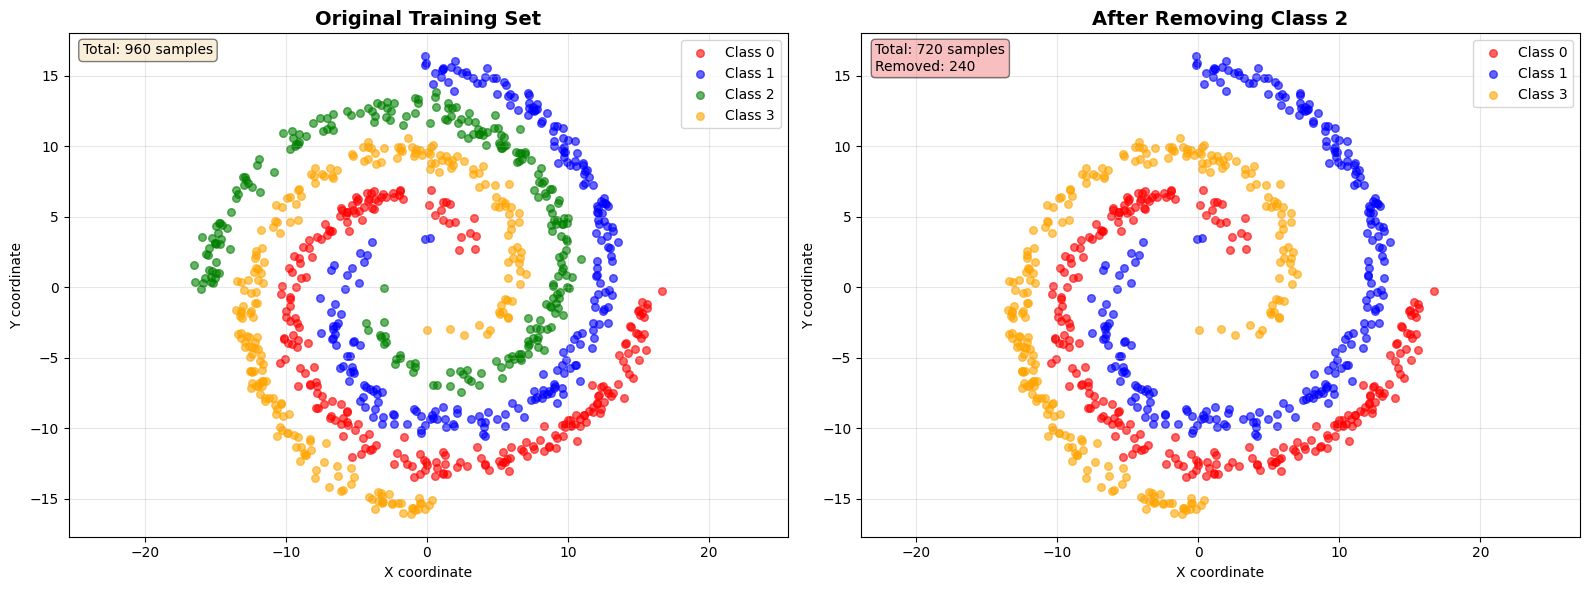


✓ Forget Request 1 complete: Class 2 removed
  Data reduction: 960 → 720 samples (25.0% removed)


In [46]:
# Visualize Forget Request 1
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
colors = ['red', 'blue', 'green', 'orange']

# Plot 1: Original training set
for class_idx in range(num_classes):
    class_mask = y_train == class_idx
    axes[0].scatter(X_train[class_mask, 0], X_train[class_mask, 1],
                   c=colors[class_idx], label=f'Class {class_idx}',
                   alpha=0.6, s=30)
axes[0].set_title('Original Training Set', fontsize=14, fontweight='bold')
axes[0].set_xlabel('X coordinate')
axes[0].set_ylabel('Y coordinate')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)
axes[0].axis('equal')
axes[0].text(0.02, 0.98, f'Total: {len(y_train)} samples', 
            transform=axes[0].transAxes, fontsize=10, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: After removing Class 2
for class_idx in range(num_classes):
    class_mask = y_train_forget1 == class_idx
    if np.sum(class_mask) > 0:  # Only plot if class exists
        axes[1].scatter(X_train_forget1[class_mask, 0], X_train_forget1[class_mask, 1],
                       c=colors[class_idx], label=f'Class {class_idx}',
                       alpha=0.6, s=30)

axes[1].set_title(f'After Removing Class {class_to_remove}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('X coordinate')
axes[1].set_ylabel('Y coordinate')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')
axes[1].text(0.02, 0.98, f'Total: {len(y_train_forget1)} samples\nRemoved: {len(y_train) - len(y_train_forget1)}', 
            transform=axes[1].transAxes, fontsize=10, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\n✓ Forget Request 1 complete: Class {class_to_remove} removed")
print(f"  Data reduction: {len(y_train)} → {len(y_train_forget1)} samples ({(1 - len(y_train_forget1)/len(y_train))*100:.1f}% removed)")

### Forget Request 2: Remove Outer Section of One Class

**Scenario**: Remove the outer 40% of Class 1 samples (by radius from origin).

**Impact**:
- Removes ~96 samples (outer edge of one spiral)
- Class 1 loses its outermost points
- Other classes remain fully intact
- Model may struggle with edge cases for Class 1

**Real-world analogy**: Remove data from users who exhibit extreme behavior in one category.

In [47]:
# Forget Request 2: Remove outer section of Class 1
print("=" * 60)
print("FORGET REQUEST 2: REMOVE OUTER SECTION OF ONE CLASS")
print("=" * 60)
print(f"Original training set size: {len(y_train)}")
print()

class_to_trim = 1
percentile_to_keep = 60  # Keep inner 60%, remove outer 40%

X_train_forget2, y_train_forget2, mask_forget2 = remove_outer_section(
    X_train.copy(), y_train.copy(), class_to_trim, percentile=percentile_to_keep
)

print(f"\nClass distribution after removal:")
for class_id in range(num_classes):
    count = np.sum(y_train_forget2 == class_id)
    original_count = np.sum(y_train == class_id)
    if class_id == class_to_trim:
        print(f"  Class {class_id}: {count} samples (was {original_count}, removed {original_count - count})")
    else:
        print(f"  Class {class_id}: {count} samples (unchanged)")

FORGET REQUEST 2: REMOVE OUTER SECTION OF ONE CLASS
Original training set size: 960

Removed 96 outer samples from Class 1 (outer 40%)
Remaining samples in Class 1: 144
Total remaining samples: 864

Class distribution after removal:
  Class 0: 240 samples (unchanged)
  Class 1: 144 samples (was 240, removed 96)
  Class 2: 240 samples (unchanged)
  Class 3: 240 samples (unchanged)


### Visualize Forget Request 2

Compare the original training set with the dataset after removing outer 40% of Class 1.

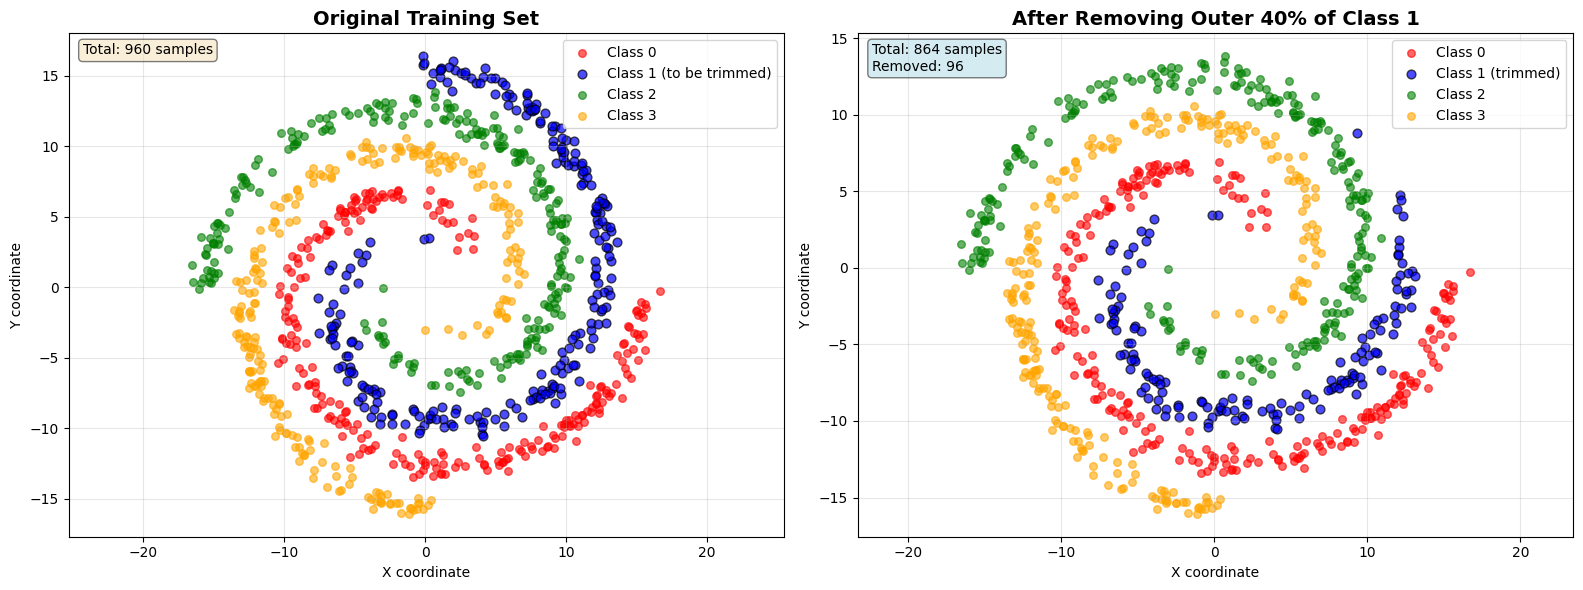


✓ Forget Request 2 complete: Outer 40% of Class 1 removed
  Data reduction: 960 → 864 samples (10.0% removed)


In [48]:
# Visualize Forget Request 2
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
colors = ['red', 'blue', 'green', 'orange']

# Plot 1: Original training set with Class 1 highlighted
for class_idx in range(num_classes):
    class_mask = y_train == class_idx
    if class_idx == class_to_trim:
        # Highlight the class that will be trimmed
        axes[0].scatter(X_train[class_mask, 0], X_train[class_mask, 1],
                       c=colors[class_idx], label=f'Class {class_idx} (to be trimmed)',
                       alpha=0.7, s=40, edgecolors='black', linewidths=1)
    else:
        axes[0].scatter(X_train[class_mask, 0], X_train[class_mask, 1],
                       c=colors[class_idx], label=f'Class {class_idx}',
                       alpha=0.6, s=30)

axes[0].set_title('Original Training Set', fontsize=14, fontweight='bold')
axes[0].set_xlabel('X coordinate')
axes[0].set_ylabel('Y coordinate')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)
axes[0].axis('equal')
axes[0].text(0.02, 0.98, f'Total: {len(y_train)} samples', 
            transform=axes[0].transAxes, fontsize=10, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: After removing outer section of Class 1
for class_idx in range(num_classes):
    class_mask = y_train_forget2 == class_idx
    if class_idx == class_to_trim:
        axes[1].scatter(X_train_forget2[class_mask, 0], X_train_forget2[class_mask, 1],
                       c=colors[class_idx], label=f'Class {class_idx} (trimmed)',
                       alpha=0.7, s=40, edgecolors='black', linewidths=1)
    else:
        axes[1].scatter(X_train_forget2[class_mask, 0], X_train_forget2[class_mask, 1],
                       c=colors[class_idx], label=f'Class {class_idx}',
                       alpha=0.6, s=30)

axes[1].set_title(f'After Removing Outer {100-percentile_to_keep}% of Class {class_to_trim}', 
                 fontsize=14, fontweight='bold')
axes[1].set_xlabel('X coordinate')
axes[1].set_ylabel('Y coordinate')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')
axes[1].text(0.02, 0.98, f'Total: {len(y_train_forget2)} samples\nRemoved: {len(y_train) - len(y_train_forget2)}', 
            transform=axes[1].transAxes, fontsize=10, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\n✓ Forget Request 2 complete: Outer {100-percentile_to_keep}% of Class {class_to_trim} removed")
print(f"  Data reduction: {len(y_train)} → {len(y_train_forget2)} samples ({(1 - len(y_train_forget2)/len(y_train))*100:.1f}% removed)")

### Forget Request 3: Remove Outer Sections of Multiple Classes

**Scenario**: Remove the outer 40% of both Class 0 and Class 3 samples.

**Impact**:
- Removes ~192 samples (outer edges of two spirals)
- Classes 0 and 3 lose their outermost points
- Classes 1 and 2 remain fully intact
- Model may struggle with edge cases for Classes 0 and 3

**Real-world analogy**: Remove extreme behavior data across multiple user categories.

In [49]:
# Forget Request 3: Remove outer sections of Classes 0 and 3
print("=" * 60)
print("FORGET REQUEST 3: REMOVE OUTER SECTIONS OF MULTIPLE CLASSES")
print("=" * 60)
print(f"Original training set size: {len(y_train)}")
print()

classes_to_trim = [0, 3]
percentile_to_keep = 60  # Keep inner 60%, remove outer 40%

X_train_forget3, y_train_forget3, mask_forget3 = remove_outer_sections_multiple(
    X_train.copy(), y_train.copy(), classes_to_trim, percentile=percentile_to_keep
)

print(f"\nClass distribution after removal:")
for class_id in range(num_classes):
    count = np.sum(y_train_forget3 == class_id)
    original_count = np.sum(y_train == class_id)
    if class_id in classes_to_trim:
        print(f"  Class {class_id}: {count} samples (was {original_count}, removed {original_count - count})")
    else:
        print(f"  Class {class_id}: {count} samples (unchanged)")

FORGET REQUEST 3: REMOVE OUTER SECTIONS OF MULTIPLE CLASSES
Original training set size: 960

Removed 96 outer samples from Class 0 (outer 40%)
Removed 96 outer samples from Class 3 (outer 40%)

Total remaining samples: 768

Class distribution after removal:
  Class 0: 144 samples (was 240, removed 96)
  Class 1: 240 samples (unchanged)
  Class 2: 240 samples (unchanged)
  Class 3: 144 samples (was 240, removed 96)


### Visualize Forget Request 3

Compare the original training set with the dataset after removing outer 40% of Classes 0 and 3.

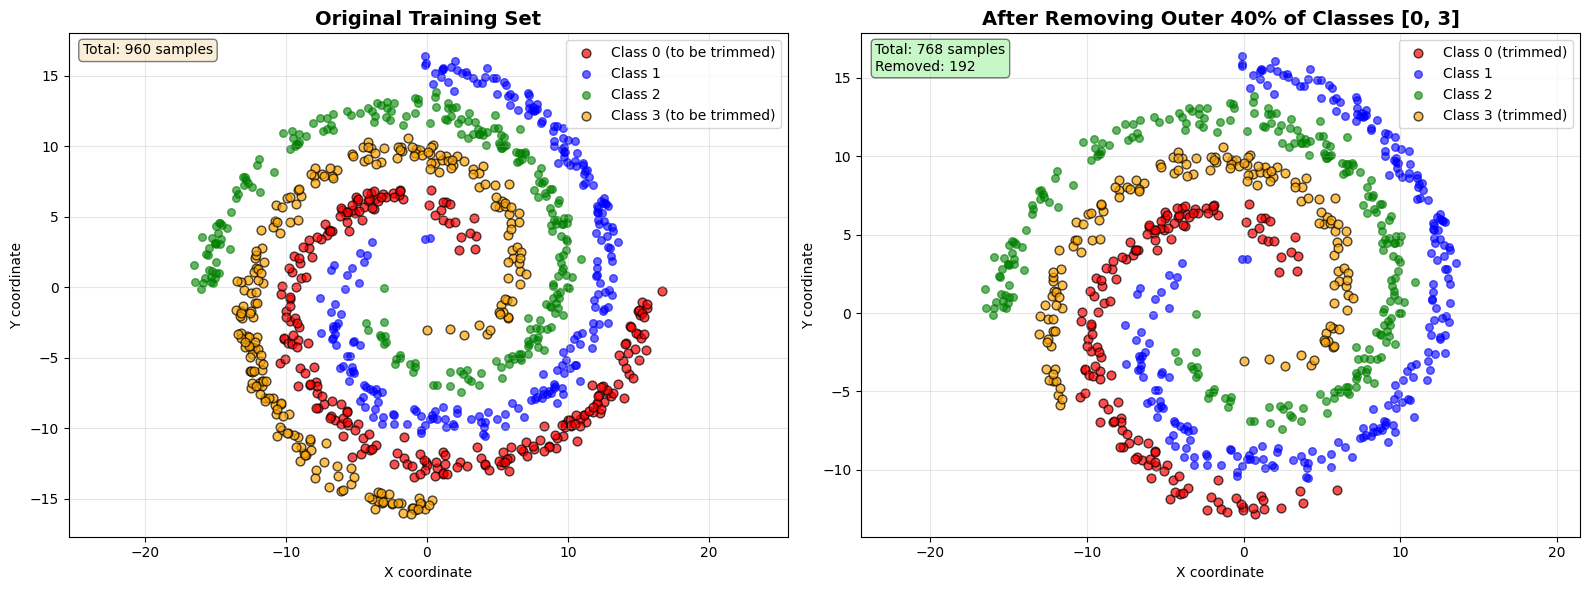


✓ Forget Request 3 complete: Outer 40% of Classes [0, 3] removed
  Data reduction: 960 → 768 samples (20.0% removed)


In [50]:
# Visualize Forget Request 3
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
colors = ['red', 'blue', 'green', 'orange']

# Plot 1: Original training set with Classes 0 and 3 highlighted
for class_idx in range(num_classes):
    class_mask = y_train == class_idx
    if class_idx in classes_to_trim:
        axes[0].scatter(X_train[class_mask, 0], X_train[class_mask, 1],
                       c=colors[class_idx], label=f'Class {class_idx} (to be trimmed)',
                       alpha=0.7, s=40, edgecolors='black', linewidths=1)
    else:
        axes[0].scatter(X_train[class_mask, 0], X_train[class_mask, 1],
                       c=colors[class_idx], label=f'Class {class_idx}',
                       alpha=0.6, s=30)

axes[0].set_title('Original Training Set', fontsize=14, fontweight='bold')
axes[0].set_xlabel('X coordinate')
axes[0].set_ylabel('Y coordinate')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)
axes[0].axis('equal')
axes[0].text(0.02, 0.98, f'Total: {len(y_train)} samples', 
            transform=axes[0].transAxes, fontsize=10, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: After removing outer sections of Classes 0 and 3
for class_idx in range(num_classes):
    class_mask = y_train_forget3 == class_idx
    if class_idx in classes_to_trim:
        axes[1].scatter(X_train_forget3[class_mask, 0], X_train_forget3[class_mask, 1],
                       c=colors[class_idx], label=f'Class {class_idx} (trimmed)',
                       alpha=0.7, s=40, edgecolors='black', linewidths=1)
    else:
        axes[1].scatter(X_train_forget3[class_mask, 0], X_train_forget3[class_mask, 1],
                       c=colors[class_idx], label=f'Class {class_idx}',
                       alpha=0.6, s=30)

axes[1].set_title(f'After Removing Outer {100-percentile_to_keep}% of Classes {classes_to_trim}', 
                 fontsize=14, fontweight='bold')
axes[1].set_xlabel('X coordinate')
axes[1].set_ylabel('Y coordinate')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')
axes[1].text(0.02, 0.98, f'Total: {len(y_train_forget3)} samples\nRemoved: {len(y_train) - len(y_train_forget3)}', 
            transform=axes[1].transAxes, fontsize=10, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()
print(f"\n✓ Forget Request 3 complete: Outer {100-percentile_to_keep}% of Classes {classes_to_trim} removed")
print(f"  Data reduction: {len(y_train)} → {len(y_train_forget3)} samples ({(1 - len(y_train_forget3)/len(y_train))*100:.1f}% removed)")

### Summary: All Three Forget Requests

Compare all three forget scenarios side by side.

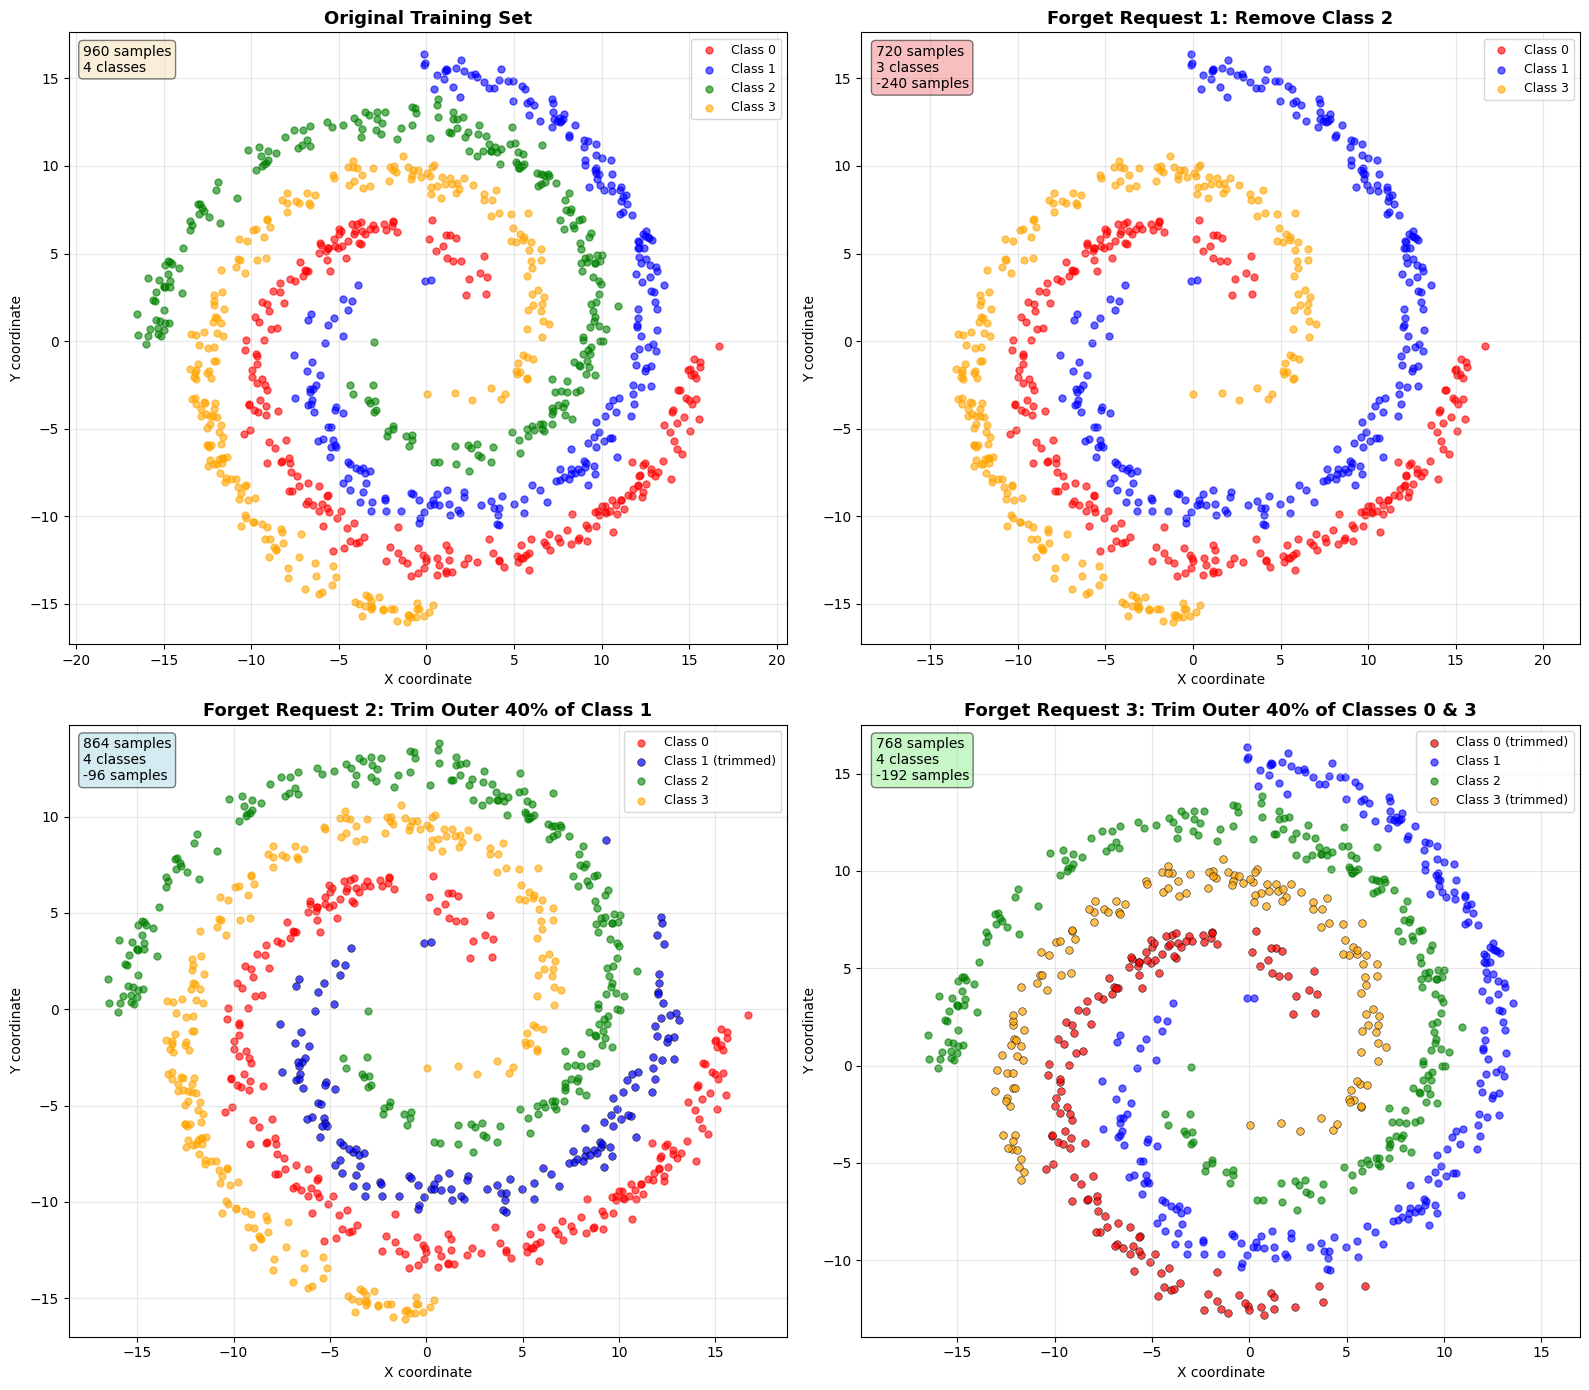

FORGET REQUESTS SUMMARY

Original Training Set: 960 samples

Forget Request 1 (Remove Class 2):
  Remaining: 720 samples (75.0%)
  Removed: 240 samples (25.0%)

Forget Request 2 (Trim Class 1):
  Remaining: 864 samples (90.0%)
  Removed: 96 samples (10.0%)

Forget Request 3 (Trim Classes 0 & 3):
  Remaining: 768 samples (80.0%)
  Removed: 192 samples (20.0%)


In [51]:
# Summary visualization: All three forget requests
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
colors = ['red', 'blue', 'green', 'orange']

# Plot 0: Original
for class_idx in range(num_classes):
    class_mask = y_train == class_idx
    axes[0, 0].scatter(X_train[class_mask, 0], X_train[class_mask, 1],
                      c=colors[class_idx], label=f'Class {class_idx}',
                      alpha=0.6, s=25)
axes[0, 0].set_title('Original Training Set', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('X coordinate')
axes[0, 0].set_ylabel('Y coordinate')
axes[0, 0].legend(loc='upper right', fontsize=9)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axis('equal')
axes[0, 0].text(0.02, 0.98, f'{len(y_train)} samples\n4 classes', 
               transform=axes[0, 0].transAxes, fontsize=10, 
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 1: Forget Request 1 (Remove Class 2)
for class_idx in range(num_classes):
    class_mask = y_train_forget1 == class_idx
    if np.sum(class_mask) > 0:
        axes[0, 1].scatter(X_train_forget1[class_mask, 0], X_train_forget1[class_mask, 1],
                          c=colors[class_idx], label=f'Class {class_idx}',
                          alpha=0.6, s=25)
axes[0, 1].set_title('Forget Request 1: Remove Class 2', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('X coordinate')
axes[0, 1].set_ylabel('Y coordinate')
axes[0, 1].legend(loc='upper right', fontsize=9)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axis('equal')
axes[0, 1].text(0.02, 0.98, f'{len(y_train_forget1)} samples\n3 classes\n-{len(y_train) - len(y_train_forget1)} samples', 
               transform=axes[0, 1].transAxes, fontsize=10, 
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

# Plot 2: Forget Request 2 (Trim Class 1)
for class_idx in range(num_classes):
    class_mask = y_train_forget2 == class_idx
    if class_idx == class_to_trim:
        axes[1, 0].scatter(X_train_forget2[class_mask, 0], X_train_forget2[class_mask, 1],
                          c=colors[class_idx], label=f'Class {class_idx} (trimmed)',
                          alpha=0.7, s=30, edgecolors='black', linewidths=0.5)
    else:
        axes[1, 0].scatter(X_train_forget2[class_mask, 0], X_train_forget2[class_mask, 1],
                          c=colors[class_idx], label=f'Class {class_idx}',
                          alpha=0.6, s=25)
axes[1, 0].set_title('Forget Request 2: Trim Outer 40% of Class 1', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('X coordinate')
axes[1, 0].set_ylabel('Y coordinate')
axes[1, 0].legend(loc='upper right', fontsize=9)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axis('equal')
axes[1, 0].text(0.02, 0.98, f'{len(y_train_forget2)} samples\n4 classes\n-{len(y_train) - len(y_train_forget2)} samples', 
               transform=axes[1, 0].transAxes, fontsize=10, 
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# Plot 3: Forget Request 3 (Trim Classes 0 and 3)
for class_idx in range(num_classes):
    class_mask = y_train_forget3 == class_idx
    if class_idx in classes_to_trim:
        axes[1, 1].scatter(X_train_forget3[class_mask, 0], X_train_forget3[class_mask, 1],
                          c=colors[class_idx], label=f'Class {class_idx} (trimmed)',
                          alpha=0.7, s=30, edgecolors='black', linewidths=0.5)
    else:
        axes[1, 1].scatter(X_train_forget3[class_mask, 0], X_train_forget3[class_mask, 1],
                          c=colors[class_idx], label=f'Class {class_idx}',
                          alpha=0.6, s=25)
axes[1, 1].set_title('Forget Request 3: Trim Outer 40% of Classes 0 & 3', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('X coordinate')
axes[1, 1].set_ylabel('Y coordinate')
axes[1, 1].legend(loc='upper right', fontsize=9)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axis('equal')
axes[1, 1].text(0.02, 0.98, f'{len(y_train_forget3)} samples\n4 classes\n-{len(y_train) - len(y_train_forget3)} samples', 
               transform=axes[1, 1].transAxes, fontsize=10, 
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 70)
print("FORGET REQUESTS SUMMARY")
print("=" * 70)
print(f"\nOriginal Training Set: {len(y_train)} samples")
print(f"\nForget Request 1 (Remove Class 2):")
print(f"  Remaining: {len(y_train_forget1)} samples ({len(y_train_forget1)/len(y_train)*100:.1f}%)")
print(f"  Removed: {len(y_train) - len(y_train_forget1)} samples ({(1 - len(y_train_forget1)/len(y_train))*100:.1f}%)")
print(f"\nForget Request 2 (Trim Class 1):")
print(f"  Remaining: {len(y_train_forget2)} samples ({len(y_train_forget2)/len(y_train)*100:.1f}%)")
print(f"  Removed: {len(y_train) - len(y_train_forget2)} samples ({(1 - len(y_train_forget2)/len(y_train))*100:.1f}%)")
print(f"\nForget Request 3 (Trim Classes 0 & 3):")
print(f"  Remaining: {len(y_train_forget3)} samples ({len(y_train_forget3)/len(y_train)*100:.1f}%)")
print(f"  Removed: {len(y_train) - len(y_train_forget3)} samples ({(1 - len(y_train_forget3)/len(y_train))*100:.1f}%)")
print("=" * 70)

## Machine Unlearning: Comprehensive Evaluation

This section implements and evaluates **1 baseline + 5 noise-based unlearning strategies** on **3 different forget requests**.

**Total Experiments**: (1 baseline + 5 strategies) × 3 forget requests = **18 comparisons**

### The Baseline:
- **Retrain from Scratch**: Train a new model on only the retain set (gold standard)

### The 5 Unlearning Strategies:
1. **Gaussian Noise**: Noise scaled by parameter std (strong disruption)
2. **Laplacian Noise**: Heavy-tailed distribution (aggressive forgetting)
3. **Adaptive Noise**: Scales with parameter magnitude (targets important weights)
4. **Layer-wise Noise**: 3x more noise in later layers (disrupts decision-making)
5. **Gradient-based Noise**: **Gradient ASCENT** on forget set (maximizes loss = forgets)

### The 3 Forget Requests:
1. **Remove Entire Class** (Class 2) - ~240 samples
2. **Remove Outer 40% of One Class** (Class 1) - ~96 samples
3. **Remove Outer 40% of Two Classes** (Classes 0 & 3) - ~192 samples

### Evaluation Metrics:
- **Retain Accuracy**: Performance on data we KEEP (higher is better) ⬆️
- **Forget Accuracy**: Performance on data we FORGET (lower is better) ⬇️
- **Test Accuracy**: Generalization on unseen data (higher is better) ⬆️

### What to Expect:
- **Good unlearning** = High retain + **Low forget** + High test
- Forget accuracy should **DROP significantly** (model forgets the data)
- If forget accuracy stays high, the strategy isn't working!

### Why Compare to Baseline?
The baseline (retrain from scratch) represents **perfect unlearning** but requires full retraining.
Unlearning strategies should approach baseline performance while being **much faster** (no training needed).

In [52]:
import copy
from collections import OrderedDict

print("✓ Additional libraries imported")

✓ Additional libraries imported


### Unlearning Strategy Implementations

Define all 5 unlearning strategies as functions.

**Important**: These strategies actually DEGRADE the model's performance on the forget set:

1. **Gaussian Noise**: Adds noise scaled by parameter standard deviation (stronger disruption)
2. **Laplacian Noise**: Heavy-tailed noise for more aggressive forgetting
3. **Adaptive Noise**: Larger parameters get more noise (they're more important)
4. **Layer-wise Noise**: Later layers get 3x more noise (they make final decisions)
5. **Gradient-based**: **Gradient ASCENT** on forget set (maximizes loss = forgets)

All strategies now receive the forget set data to target their forgetting.

In [ ]:
def gaussian_noise_unlearning(model, X_forget, y_forget, noise_scale=0.01, seed=42):
    """
    Strategy 1: Gaussian Noise Injection
    
    How it works:
    - Adds random Gaussian noise to all model parameters
    - Noise magnitude is scaled by each parameter's standard deviation
    - This disrupts learned patterns associated with the forget set
    
    Intuition: Like "shaking" the model's weights to blur specific memories
    """
    # Create a deep copy to avoid modifying the original model
    unlearned = copy.deepcopy(model)
    torch.manual_seed(seed)  # Ensure reproducibility
    
    with torch.no_grad():  # No gradient computation needed
        for param in unlearned.network.parameters():
            # Calculate parameter's standard deviation
            param_std = torch.std(param)
            if param_std > 0:
                # Generate Gaussian noise: N(0, noise_scale * σ_param)
                noise = torch.randn_like(param) * noise_scale * param_std
                # Add noise in-place to the parameter
                param.add_(noise)
    
    return unlearned

def laplacian_noise_unlearning(model, X_forget, y_forget, scale=0.01, seed=42):
    """
    Strategy 2: Laplacian Noise Injection
    
    How it works:
    - Uses Laplacian distribution instead of Gaussian
    - Laplacian has heavier tails = more extreme values
    - Better at creating sharp forgetting with occasional large disruptions
    
    Intuition: Like Gaussian but with more aggressive "spikes" in the noise
    """
    unlearned = copy.deepcopy(model)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    with torch.no_grad():
        for param in unlearned.network.parameters():
            param_std = torch.std(param).item()
            if param_std > 0:
                # Generate Laplacian noise in numpy (PyTorch doesn't have built-in Laplacian)
                noise_np = np.random.laplace(0, scale * param_std, param.shape)
                # Convert back to PyTorch tensor
                noise = torch.tensor(noise_np, dtype=param.dtype, device=param.device)
                param.add_(noise)
    
    return unlearned

def adaptive_noise_unlearning(model, X_forget, y_forget, noise_scale=0.02, seed=42):
    """
    Strategy 3: Adaptive (Magnitude-Proportional) Noise
    
    How it works:
    - Noise magnitude scales with the absolute value of each parameter
    - Larger weights get more noise, smaller weights get less
    - Targets more "important" parameters that likely store more information
    
    Intuition: Attack the strongest connections first (they hold more memory)
    """
    unlearned = copy.deepcopy(model)
    torch.manual_seed(seed)
    
    with torch.no_grad():
        for param in unlearned.network.parameters():
            # Generate base noise
            noise = torch.randn_like(param) * noise_scale
            # Scale noise by parameter magnitude: larger weights → more noise
            adaptive_noise = noise * torch.abs(param)
            param.add_(adaptive_noise)
    
    return unlearned

def layerwise_noise_unlearning(model, X_forget, y_forget, base_scale=0.01, scale_factor=2.0, seed=42):
    """
    Strategy 4: Layer-wise Progressive Noise
    
    How it works:
    - Earlier layers (feature extractors) get less noise
    - Later layers (decision makers) get more noise
    - Progression is linear from base_scale to (base_scale * scale_factor)
    
    Intuition: Final layers make the actual classifications, so disrupting
               them is more effective for forgetting specific classes
    """
    unlearned = copy.deepcopy(model)
    torch.manual_seed(seed)
    
    params = list(unlearned.network.parameters())
    num_params = len(params)
    
    with torch.no_grad():
        for idx, param in enumerate(params):
            # Calculate progress through the network (0.0 to 1.0)
            layer_progress = idx / max(num_params - 1, 1)
            # Scale increases linearly: base_scale → base_scale * scale_factor
            layer_scale = base_scale * (1 + layer_progress * (scale_factor - 1))
            
            param_std = torch.std(param)
            if param_std > 0:
                noise = torch.randn_like(param) * layer_scale * param_std
                param.add_(noise)
    
    return unlearned

def gradient_based_noise_unlearning(model, X_forget, y_forget, lr=0.002, steps=2, noise_scale=0.005, seed=42):
    """
    Strategy 5: Gradient Ascent + Noise
    
    How it works:
    1. Perform gradient ASCENT on forget set (opposite of training)
       - Normal training minimizes loss (gradient descent)
       - Here we MAXIMIZE loss (gradient ascent) to "unlearn"
    2. Add small Gaussian noise for additional disruption
    
    Intuition: Actively push the model to perform WORSE on forget data,
               then add noise to prevent simply memorizing the reverse pattern
    
    This is the most sophisticated approach as it's data-aware.
    """
    unlearned = copy.deepcopy(model)
    torch.manual_seed(seed)
    
    # Convert forget set to PyTorch tensors
    X_tensor = torch.FloatTensor(X_forget)
    y_tensor = torch.LongTensor(y_forget)
    
    # Setup for gradient ascent
    unlearned.network.train()  # Enable gradient computation
    optimizer = torch.optim.SGD(unlearned.network.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    # Perform gradient ascent steps
    for step in range(steps):
        optimizer.zero_grad()
        output, _ = unlearned.network(X_tensor)
        loss = criterion(output, y_tensor)
        
        # KEY: Negative loss for gradient ASCENT (maximize loss)
        # This makes the model worse at predicting the forget set
        (-loss).backward()
        optimizer.step()
    
    # Add small random noise to prevent overfitting to the ascent
    with torch.no_grad():
        for param in unlearned.network.parameters():
            param_std = torch.std(param)
            if param_std > 0:
                noise = torch.randn_like(param) * noise_scale * param_std
                param.add_(noise)
    
    unlearned.network.eval()  # Back to evaluation mode
    return unlearned

print("✓ All 5 unlearning strategies defined with detailed comments")

✓ All 5 unlearning strategies defined (ultra-conservative noise)


### Prepare All Forget Request Datasets

Standardize data for all three forget requests.

In [ ]:
from sklearn.preprocessing import StandardScaler

print("Preparing datasets for all forget requests...")
print("=" * 70)

# Dictionary to store all datasets for the three forget scenarios
forget_datasets = {}

# ==================================================================================
# CRITICAL DESIGN DECISION: DUAL-SCALER APPROACH
# ==================================================================================
# We use TWO DIFFERENT scalers for unlearning vs. baseline:
#
# 1. UNLEARNING STRATEGIES → Use ORIGINAL scaler (fitted on full training set)
#    Why? The unlearning strategies modify an existing model. That model was
#    trained on data scaled with the original scaler, so we must use the same
#    scaling to ensure consistency. Using different scaling would invalidate
#    the entire unlearning process.
#
# 2. BASELINE (Retrain) → Use NEW scaler (fitted only on retain set)
#    Why? We're training from scratch on a smaller dataset (with data removed).
#    Best practice is to fit the scaler on your actual training data.
#    This represents the "ideal" scenario where we never trained on forget data.
#
# This dual approach ensures fair comparison while maintaining methodological rigor.
# ==================================================================================

# ---------------------------------------------------------------------------------
# FORGET REQUEST 1: Remove Entire Class 2 (~240 samples removed)
# ---------------------------------------------------------------------------------
print(f"\nFR1: Remove Class 2")

# Split into retain (keep) and forget (remove) sets
X_retain_fr1 = X_train_forget1  # Data we keep (Classes 0, 1, 3)
y_retain_fr1 = y_train_forget1
X_forget_fr1 = X_train[~mask_forget1]  # Data we remove (Class 2)
y_forget_fr1 = y_train[~mask_forget1]

# Transform using ORIGINAL scaler for unlearning strategies
# (Remember: original TabNet model was trained with this scaler)
X_retain_fr1_original = scaler.transform(X_retain_fr1)
X_forget_fr1_original = scaler.transform(X_forget_fr1)
X_test_original = scaler.transform(X_test)

# Create NEW scaler for baseline retraining
# This scaler only "knows" about the retain set, never saw forget data
scaler_fr1_baseline = StandardScaler()
X_retain_fr1_baseline = scaler_fr1_baseline.fit_transform(X_retain_fr1)
X_test_fr1_baseline = scaler_fr1_baseline.transform(X_test)

forget_datasets['FR1: Remove Class 2'] = {
    # For unlearning strategies (use original scaling)
    'X_retain': X_retain_fr1_original,
    'y_retain': y_retain_fr1,
    'X_forget': X_forget_fr1_original,
    'y_forget': y_forget_fr1,
    'X_test': X_test_original,
    'y_test': y_test,
    # For baseline (use new scaling)
    'X_retain_baseline': X_retain_fr1_baseline,
    'X_test_baseline': X_test_fr1_baseline
}

print(f"FR1: Remove Class 2")
print(f"  Retain: {len(y_retain_fr1)} samples | Forget: {len(y_forget_fr1)} samples")

# FR2: Trim Class 1 (40%)
X_retain_fr2 = X_train_forget2
y_retain_fr2 = y_train_forget2
X_forget_fr2 = X_train[~mask_forget2]
y_forget_fr2 = y_train[~mask_forget2]

X_retain_fr2_original = scaler.transform(X_retain_fr2)
X_forget_fr2_original = scaler.transform(X_forget_fr2)

scaler_fr2_baseline = StandardScaler()
X_retain_fr2_baseline = scaler_fr2_baseline.fit_transform(X_retain_fr2)
X_test_fr2_baseline = scaler_fr2_baseline.transform(X_test)

forget_datasets['FR2: Trim Class 1 (40%)'] = {
    'X_retain': X_retain_fr2_original,
    'y_retain': y_retain_fr2,
    'X_forget': X_forget_fr2_original,
    'y_forget': y_forget_fr2,
    'X_test': X_test_original,
    'y_test': y_test,
    'X_retain_baseline': X_retain_fr2_baseline,
    'X_test_baseline': X_test_fr2_baseline
}

print(f"FR2: Trim Class 1 (40%)")
print(f"  Retain: {len(y_retain_fr2)} samples | Forget: {len(y_forget_fr2)} samples")

# FR3: Trim Classes 0 & 3 (40%)
X_retain_fr3 = X_train_forget3
y_retain_fr3 = y_train_forget3
X_forget_fr3 = X_train[~mask_forget3]
y_forget_fr3 = y_train[~mask_forget3]

X_retain_fr3_original = scaler.transform(X_retain_fr3)
X_forget_fr3_original = scaler.transform(X_forget_fr3)

scaler_fr3_baseline = StandardScaler()
X_retain_fr3_baseline = scaler_fr3_baseline.fit_transform(X_retain_fr3)
X_test_fr3_baseline = scaler_fr3_baseline.transform(X_test)

forget_datasets['FR3: Trim Classes 0&3 (40%)'] = {
    'X_retain': X_retain_fr3_original,
    'y_retain': y_retain_fr3,
    'X_forget': X_forget_fr3_original,
    'y_forget': y_forget_fr3,
    'X_test': X_test_original,
    'y_test': y_test,
    'X_retain_baseline': X_retain_fr3_baseline,
    'X_test_baseline': X_test_fr3_baseline
}

print(f"FR3: Trim Classes 0 & 3 (40%)")
print(f"  Retain: {len(y_retain_fr3)} samples | Forget: {len(y_forget_fr3)} samples")

print("=" * 70)
print("✓ All datasets prepared!")
print()
print("SCALING STRATEGY:")
print("  • Unlearning: Uses ORIGINAL scaler (from full training set)")
print("  • Baseline: Uses NEW scaler (from retain set only)")
print("  • This ensures fair comparison - unlearning sees same data as original model")

Preparing datasets for all forget requests...


NameError: name 'scaler' is not defined

### Run Comprehensive Evaluation

Test all 5 strategies on all 3 forget requests (15 experiments total).

This will take a few minutes to complete.

### Baseline: Retrain from Scratch

Before testing unlearning strategies, we need a **baseline**: retrain TabNet from scratch on each retain set.

This represents the "gold standard" - what accuracy we'd get if we could perfectly forget.

In [ ]:
print("=" * 80)
print("TRAINING BASELINE MODELS (RETRAIN FROM SCRATCH)")
print("=" * 80)

baseline_results = {}

for forget_name, dataset in forget_datasets.items():
    print(f"\nRetraining for: {forget_name}...")
    
    # Create fresh TabNet model
    baseline_model = TabNetClassifier(
        n_d=64,
        n_a=64,
        n_steps=5,
        gamma=1.5,
        lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params={"step_size":50, "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='entmax',
        verbose=0
    )
    
    # Train on retain set only
    baseline_model.fit(
        dataset['X_retain_baseline'], dataset['y_retain'],
        max_epochs=100,
        patience=20,
        batch_size=256,
        virtual_batch_size=128
    )
    
    # Evaluate
    retain_acc = accuracy_score(dataset['y_retain'], baseline_model.predict(dataset['X_retain_baseline']))
    forget_acc = accuracy_score(dataset['y_forget'], baseline_model.predict(dataset['X_forget']))
    test_acc = accuracy_score(dataset['y_test'], baseline_model.predict(dataset['X_test_baseline']))
    
    baseline_results[forget_name] = {
        'retain': retain_acc,
        'forget': forget_acc,
        'test': test_acc
    }
    
    print(f"  Retain: {retain_acc:.4f} | Forget: {forget_acc:.4f} | Test: {test_acc:.4f}")

print("\n" + "=" * 80)
print("✓ Baseline models trained!")
print("=" * 80)

TRAINING BASELINE MODELS (RETRAIN FROM SCRATCH)

Retraining for: FR1: Remove Class 2...


/Users/eshaanmittal/Desktop/UB/TFG/Codes/venv/lib/python3.13/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


  Retain: 0.9903 | Forget: 0.0000 | Test: 0.7417

Retraining for: FR2: Trim Class 1 (40%)...


/Users/eshaanmittal/Desktop/UB/TFG/Codes/venv/lib/python3.13/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


  Retain: 0.9919 | Forget: 0.4896 | Test: 0.9000

Retraining for: FR3: Trim Classes 0&3 (40%)...


/Users/eshaanmittal/Desktop/UB/TFG/Codes/venv/lib/python3.13/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


  Retain: 0.9870 | Forget: 0.3385 | Test: 0.8667

✓ Baseline models trained!


In [ ]:
print("=" * 80)
print("COMPREHENSIVE EVALUATION: 5 STRATEGIES × 3 FORGET REQUESTS = 15 EXPERIMENTS")
print("=" * 80)

# Store all results
all_results = {}

# Define strategies with updated parameters
strategies = {
    'Gaussian': {'func': gaussian_noise_unlearning, 'params': {'noise_scale': 0.01}},
    'Laplacian': {'func': laplacian_noise_unlearning, 'params': {'scale': 0.01}},
    'Adaptive': {'func': adaptive_noise_unlearning, 'params': {'noise_scale': 0.02}},
    'Layer-wise': {'func': layerwise_noise_unlearning, 
                   'params': {'base_scale': 0.01, 'scale_factor': 2.0}},
    'Gradient-based': {'func': gradient_based_noise_unlearning, 
                       'params': {'lr': 0.002, 'steps': 2, 'noise_scale': 0.005}}
}

experiment_num = 0
total_experiments = len(forget_datasets) * len(strategies)

for forget_name, dataset in forget_datasets.items():
    print(f"\n{'='*80}")
    print(f"Testing: {forget_name}")
    print(f"{'='*80}")
    
    all_results[forget_name] = {}
    
    for strategy_name, config in strategies.items():
        experiment_num += 1
        print(f"[{experiment_num}/{total_experiments}] {strategy_name}...", end=' ')
        
        # ALL strategies now receive forget set data
        unlearned = config['func'](
            tabnet_model,
            dataset['X_forget'],
            dataset['y_forget'],
            **config['params']
        )
        
        # Evaluate
        retain_acc = accuracy_score(
            dataset['y_retain'],
            unlearned.predict(dataset['X_retain'])
        )
        
        forget_acc = accuracy_score(
            dataset['y_forget'],
            unlearned.predict(dataset['X_forget'])
        )
        
        test_acc = accuracy_score(
            dataset['y_test'],
            unlearned.predict(dataset['X_test'])
        )
        
        # Store
        all_results[forget_name][strategy_name] = {
            'retain': retain_acc,
            'forget': forget_acc,
            'test': test_acc
        }
        
        print(f"Retain: {retain_acc:.3f} | Forget: {forget_acc:.3f} | Test: {test_acc:.3f}")

print("\n" + "=" * 80)
print("✓ All 15 experiments complete!")
print("=" * 80)

COMPREHENSIVE EVALUATION: 5 STRATEGIES × 3 FORGET REQUESTS = 15 EXPERIMENTS

Testing: FR1: Remove Class 2
[1/15] Gaussian... Retain: 0.125 | Forget: 0.521 | Test: 0.212
[2/15] Laplacian... Retain: 0.310 | Forget: 0.000 | Test: 0.246
[3/15] Adaptive... Retain: 0.157 | Forget: 0.775 | Test: 0.362
[4/15] Layer-wise... Retain: 0.113 | Forget: 0.725 | Test: 0.287
[5/15] Gradient-based... Retain: 0.304 | Forget: 0.496 | Test: 0.375

Testing: FR2: Trim Class 1 (40%)
[6/15] Gaussian... Retain: 0.148 | Forget: 0.896 | Test: 0.212
[7/15] Laplacian... Retain: 0.257 | Forget: 0.000 | Test: 0.246
[8/15] Adaptive... Retain: 0.338 | Forget: 0.271 | Test: 0.342
[9/15] Layer-wise... Retain: 0.222 | Forget: 0.854 | Test: 0.312
[10/15] Gradient-based... Retain: 0.422 | Forget: 0.990 | Test: 0.504

Testing: FR3: Trim Classes 0&3 (40%)
[11/15] Gaussian... Retain: 0.348 | Forget: 0.005 | Test: 0.271
[12/15] Laplacian... Retain: 0.158 | Forget: 0.510 | Test: 0.254
[13/15] Adaptive... Retain: 0.443 | Forget: 

### Results Table

Display all results in a comprehensive table.

In [ ]:
print("=" * 110)
print("COMPREHENSIVE RESULTS: BASELINE + ALL STRATEGIES × ALL FORGET REQUESTS")
print("=" * 110)

for forget_req in forget_requests:
    print(f"\n{forget_req}")
    print("-" * 110)
    print(f"{'Strategy':<25} {'Retain Acc':<15} {'Forget Acc':<15} {'Test Acc':<15} {'Balance Score':<15}")
    print("-" * 110)
    
    # Show baseline first
    baseline = baseline_results[forget_req]
    balance = baseline['retain'] + baseline['test'] - baseline['forget']
    print(f"{'Baseline (Retrain)':<25} {baseline['retain']:<15.4f} {baseline['forget']:<15.4f} "
          f"{baseline['test']:<15.4f} {balance:.4f} ⭐")
    
    print("-" * 110)
    
    # Then show all strategies
    strategies_results = all_results[forget_req]
    for strategy, metrics in strategies_results.items():
        balance = metrics['retain'] + metrics['test'] - metrics['forget']
        print(f"{strategy:<25} {metrics['retain']:<15.4f} {metrics['forget']:<15.4f} "
              f"{metrics['test']:<15.4f} {balance:.4f}")

print("\n" + "=" * 110)
print("\nMetrics Interpretation:")
print("  • Retain Acc: Higher is better (preserve knowledge)")
print("  • Forget Acc: Lower is better (successful forgetting)")
print("  • Test Acc: Higher is better (generalization)")
print("  • Balance Score: retain + test - forget (higher is better overall)")
print("  • ⭐ Baseline = Gold standard (retrain from scratch)")
print("=" * 110)

COMPREHENSIVE RESULTS: BASELINE + ALL STRATEGIES × ALL FORGET REQUESTS

FR1: Remove Class 2
--------------------------------------------------------------------------------------------------------------
Strategy                  Retain Acc      Forget Acc      Test Acc        Balance Score  
--------------------------------------------------------------------------------------------------------------
Baseline (Retrain)        0.9903          0.0000          0.7417          1.7319 ⭐
--------------------------------------------------------------------------------------------------------------
Gaussian                  0.1250          0.5208          0.2125          -0.1833
Laplacian                 0.3097          0.0000          0.2458          0.5556
Adaptive                  0.1569          0.7750          0.3625          -0.2556
Layer-wise                0.1125          0.7250          0.2875          -0.3250
Gradient-based            0.3042          0.4958          0.3750          0

### Comprehensive Visualization

Grouped bar charts showing all 15 comparisons.

/var/folders/c5/kss3_fr539x3tp1704zq_pz40000gn/T/ipykernel_12707/481208157.py:92: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout(pad=3.0)


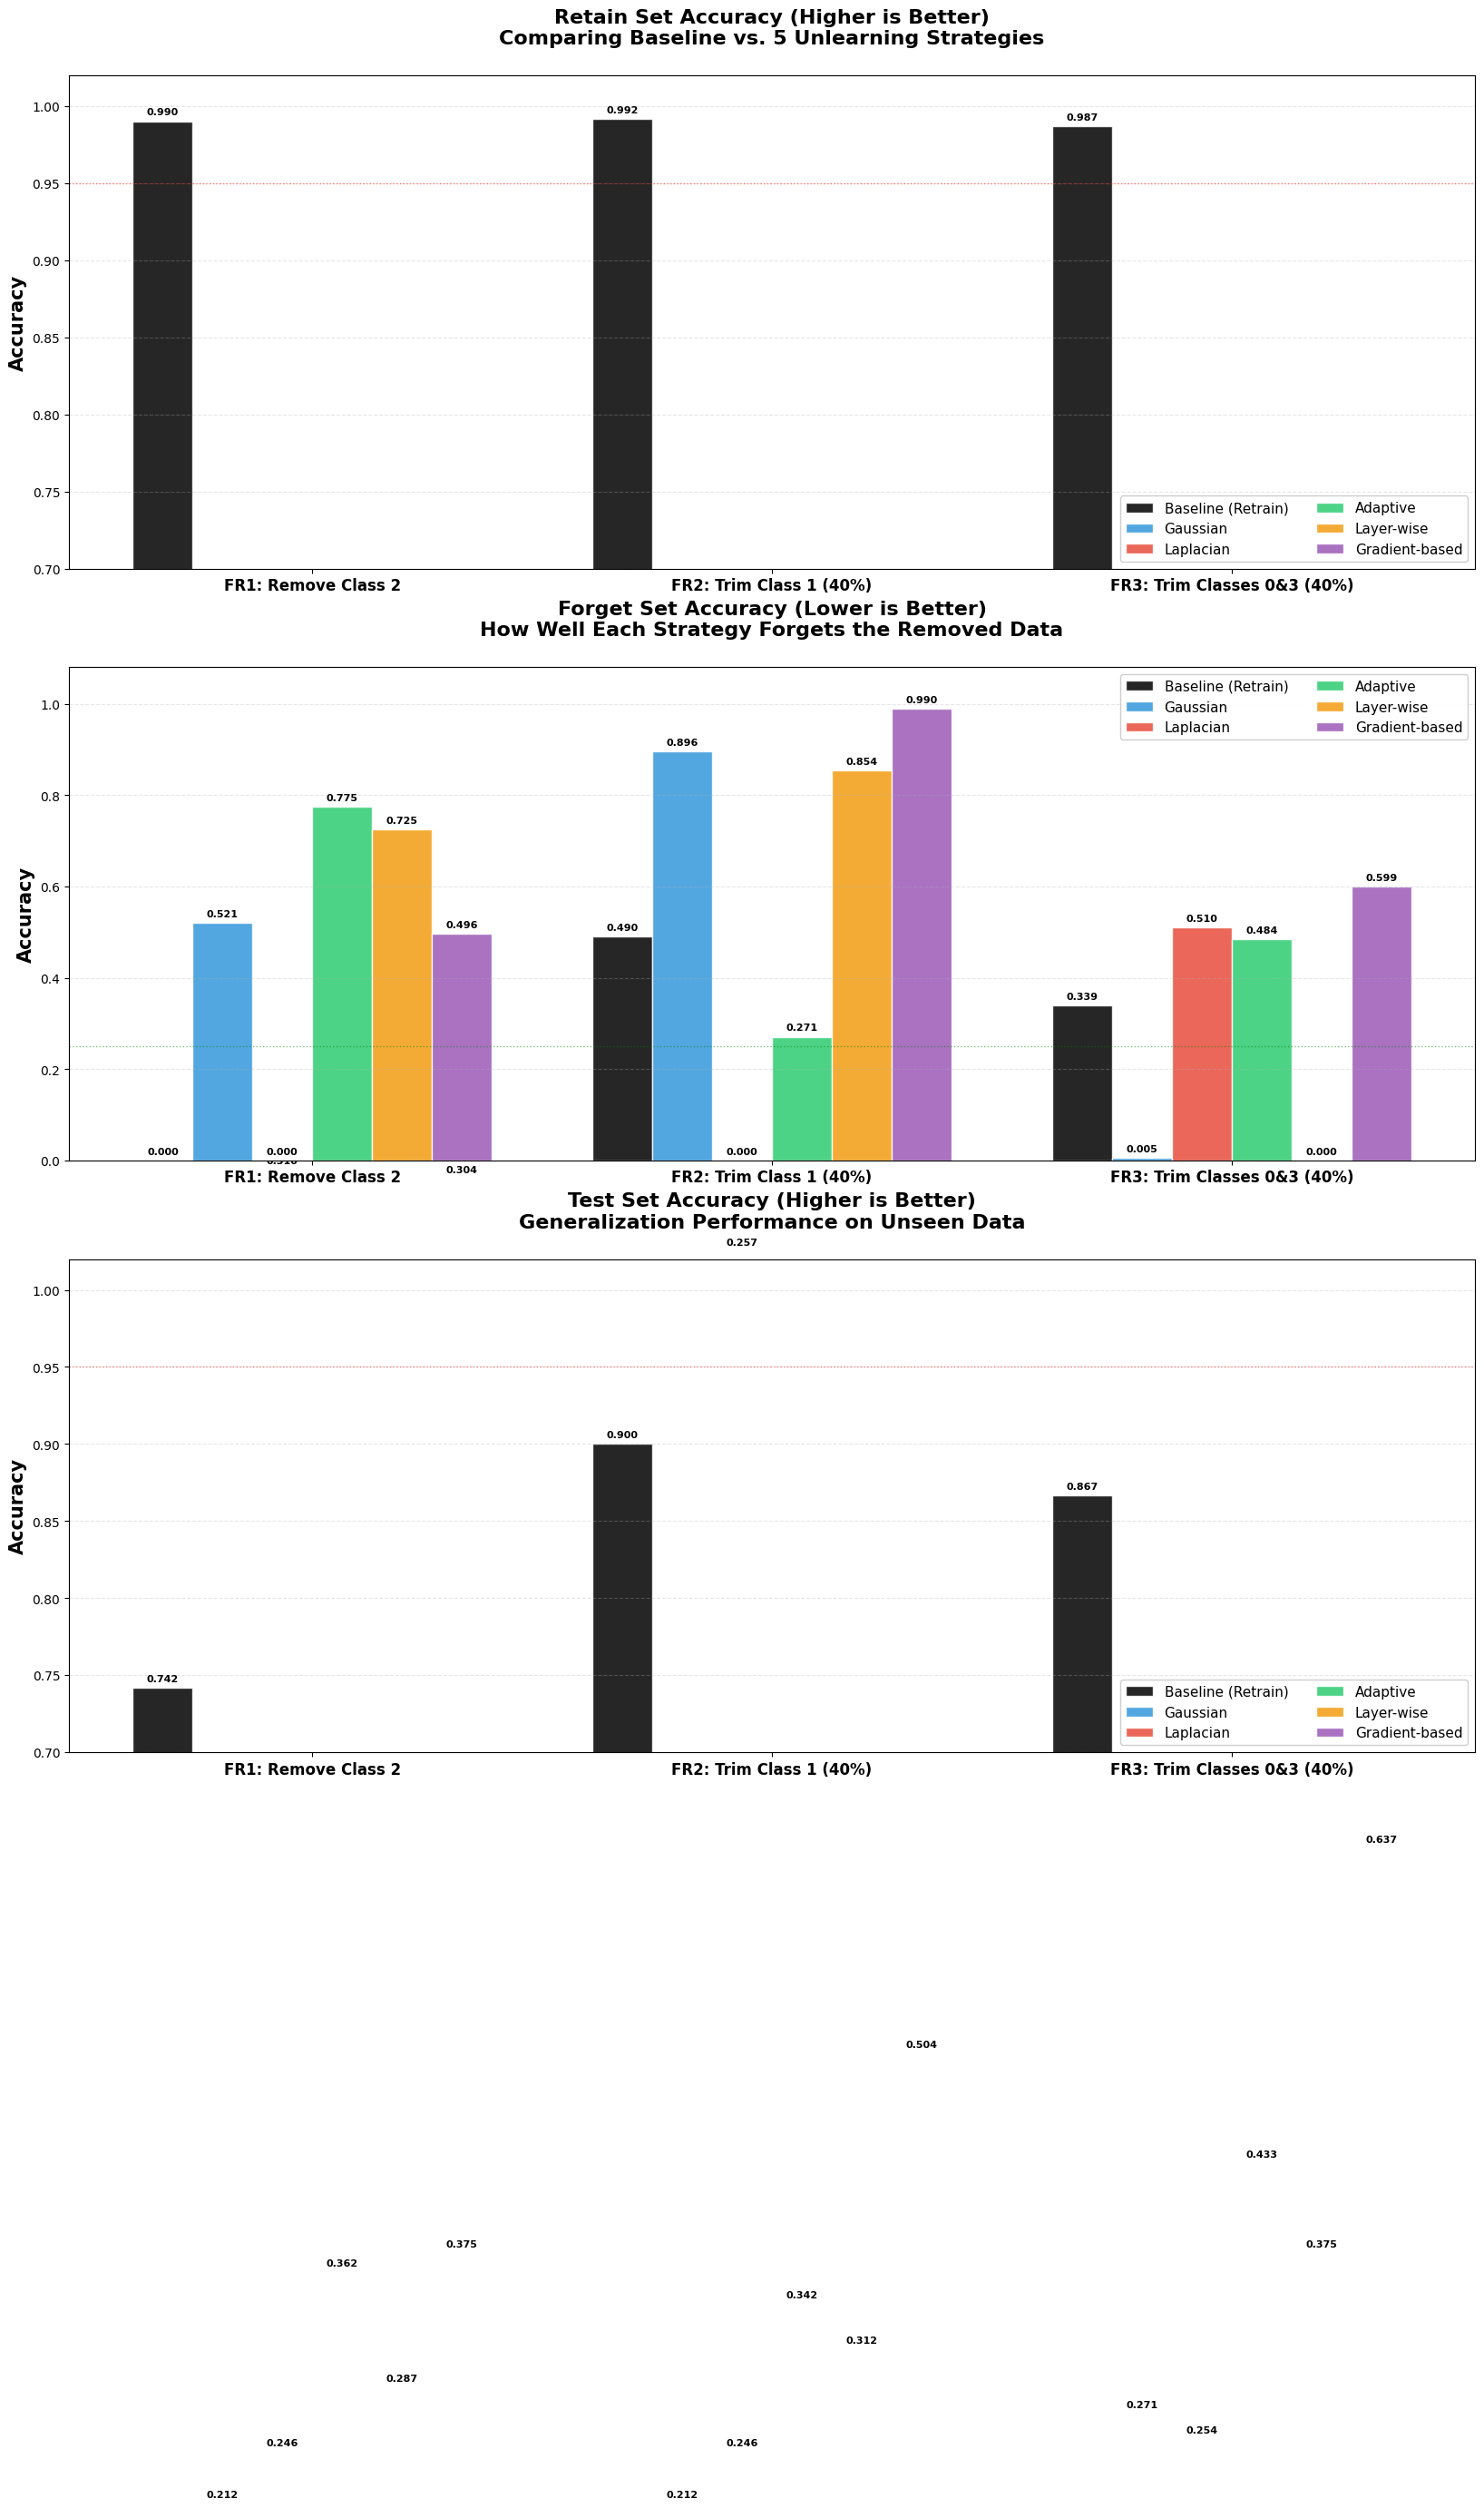


✓ Visualization complete!

Key Observations:
  • BLACK bars = Baseline (retrain from scratch) - the 'gold standard'
  • Unlearning strategies should approach baseline performance
  • Good unlearning: High retain, Low forget, High test


In [ ]:
# Prepare data for visualization (including baseline)
forget_requests = list(all_results.keys())
strategy_names = ['Baseline (Retrain)'] + list(all_results[forget_requests[0]].keys())

# Extract metrics
retain_data = {s: [] for s in strategy_names}
forget_data = {s: [] for s in strategy_names}
test_data = {s: [] for s in strategy_names}

for fr in forget_requests:
    # Add baseline first
    retain_data['Baseline (Retrain)'].append(baseline_results[fr]['retain'])
    forget_data['Baseline (Retrain)'].append(baseline_results[fr]['forget'])
    test_data['Baseline (Retrain)'].append(baseline_results[fr]['test'])
    
    # Then add all strategies
    for strategy in strategy_names[1:]:  # Skip baseline
        retain_data[strategy].append(all_results[fr][strategy]['retain'])
        forget_data[strategy].append(all_results[fr][strategy]['forget'])
        test_data[strategy].append(all_results[fr][strategy]['test'])

# Create visualization with proper spacing
fig, axes = plt.subplots(3, 1, figsize=(20, 24))

x = np.arange(len(forget_requests))
width = 0.13  # Narrower bars for 6 strategies
colors = ['#000000', '#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']  # Black for baseline

# Plot 1: Retain Accuracy
for i, strategy in enumerate(strategy_names):
    offset = width * (i - 2.5)
    bars = axes[0].bar(x + offset, retain_data[strategy], width, 
                       label=strategy, color=colors[i], alpha=0.85, edgecolor='white', linewidth=1)
    
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.003,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold', rotation=0)

axes[0].set_ylabel('Accuracy', fontsize=15, fontweight='bold')
axes[0].set_title('Retain Set Accuracy (Higher is Better)\nComparing Baseline vs. 5 Unlearning Strategies', 
                 fontsize=16, fontweight='bold', pad=25)
axes[0].set_xticks(x)
axes[0].set_xticklabels(forget_requests, fontsize=12, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=11, framealpha=0.95, ncol=2)
axes[0].grid(True, alpha=0.3, axis='y', linestyle='--')
axes[0].set_ylim([0.70, 1.02])
axes[0].axhline(y=0.95, color='red', linestyle=':', alpha=0.5, linewidth=1)

# Plot 2: Forget Accuracy
for i, strategy in enumerate(strategy_names):
    offset = width * (i - 2.5)
    bars = axes[1].bar(x + offset, forget_data[strategy], width, 
                       label=strategy, color=colors[i], alpha=0.85, edgecolor='white', linewidth=1)
    
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold', rotation=0)

axes[1].set_ylabel('Accuracy', fontsize=15, fontweight='bold')
axes[1].set_title('Forget Set Accuracy (Lower is Better)\nHow Well Each Strategy Forgets the Removed Data', 
                 fontsize=16, fontweight='bold', pad=25)
axes[1].set_xticks(x)
axes[1].set_xticklabels(forget_requests, fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=11, framealpha=0.95, ncol=2)
axes[1].grid(True, alpha=0.3, axis='y', linestyle='--')
axes[1].set_ylim([0.0, 1.08])
axes[1].axhline(y=0.25, color='green', linestyle=':', alpha=0.5, linewidth=1, label='Target (random guess)')

# Plot 3: Test Accuracy
for i, strategy in enumerate(strategy_names):
    offset = width * (i - 2.5)
    bars = axes[2].bar(x + offset, test_data[strategy], width, 
                       label=strategy, color=colors[i], alpha=0.85, edgecolor='white', linewidth=1)
    
    for bar in bars:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.003,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold', rotation=0)

axes[2].set_ylabel('Accuracy', fontsize=15, fontweight='bold')
axes[2].set_title('Test Set Accuracy (Higher is Better)\nGeneralization Performance on Unseen Data', 
                 fontsize=16, fontweight='bold', pad=25)
axes[2].set_xticks(x)
axes[2].set_xticklabels(forget_requests, fontsize=12, fontweight='bold')
axes[2].legend(loc='lower right', fontsize=11, framealpha=0.95, ncol=2)
axes[2].grid(True, alpha=0.3, axis='y', linestyle='--')
axes[2].set_ylim([0.70, 1.02])
axes[2].axhline(y=0.95, color='red', linestyle=':', alpha=0.5, linewidth=1)

plt.tight_layout(pad=3.0)
plt.show()

print("\n✓ Visualization complete!")
print("\nKey Observations:")
print("  • BLACK bars = Baseline (retrain from scratch) - the 'gold standard'")
print("  • Unlearning strategies should approach baseline performance")
print("  • Good unlearning: High retain, Low forget, High test")

### Heatmap Visualization

Heatmaps showing performance patterns across all combinations.

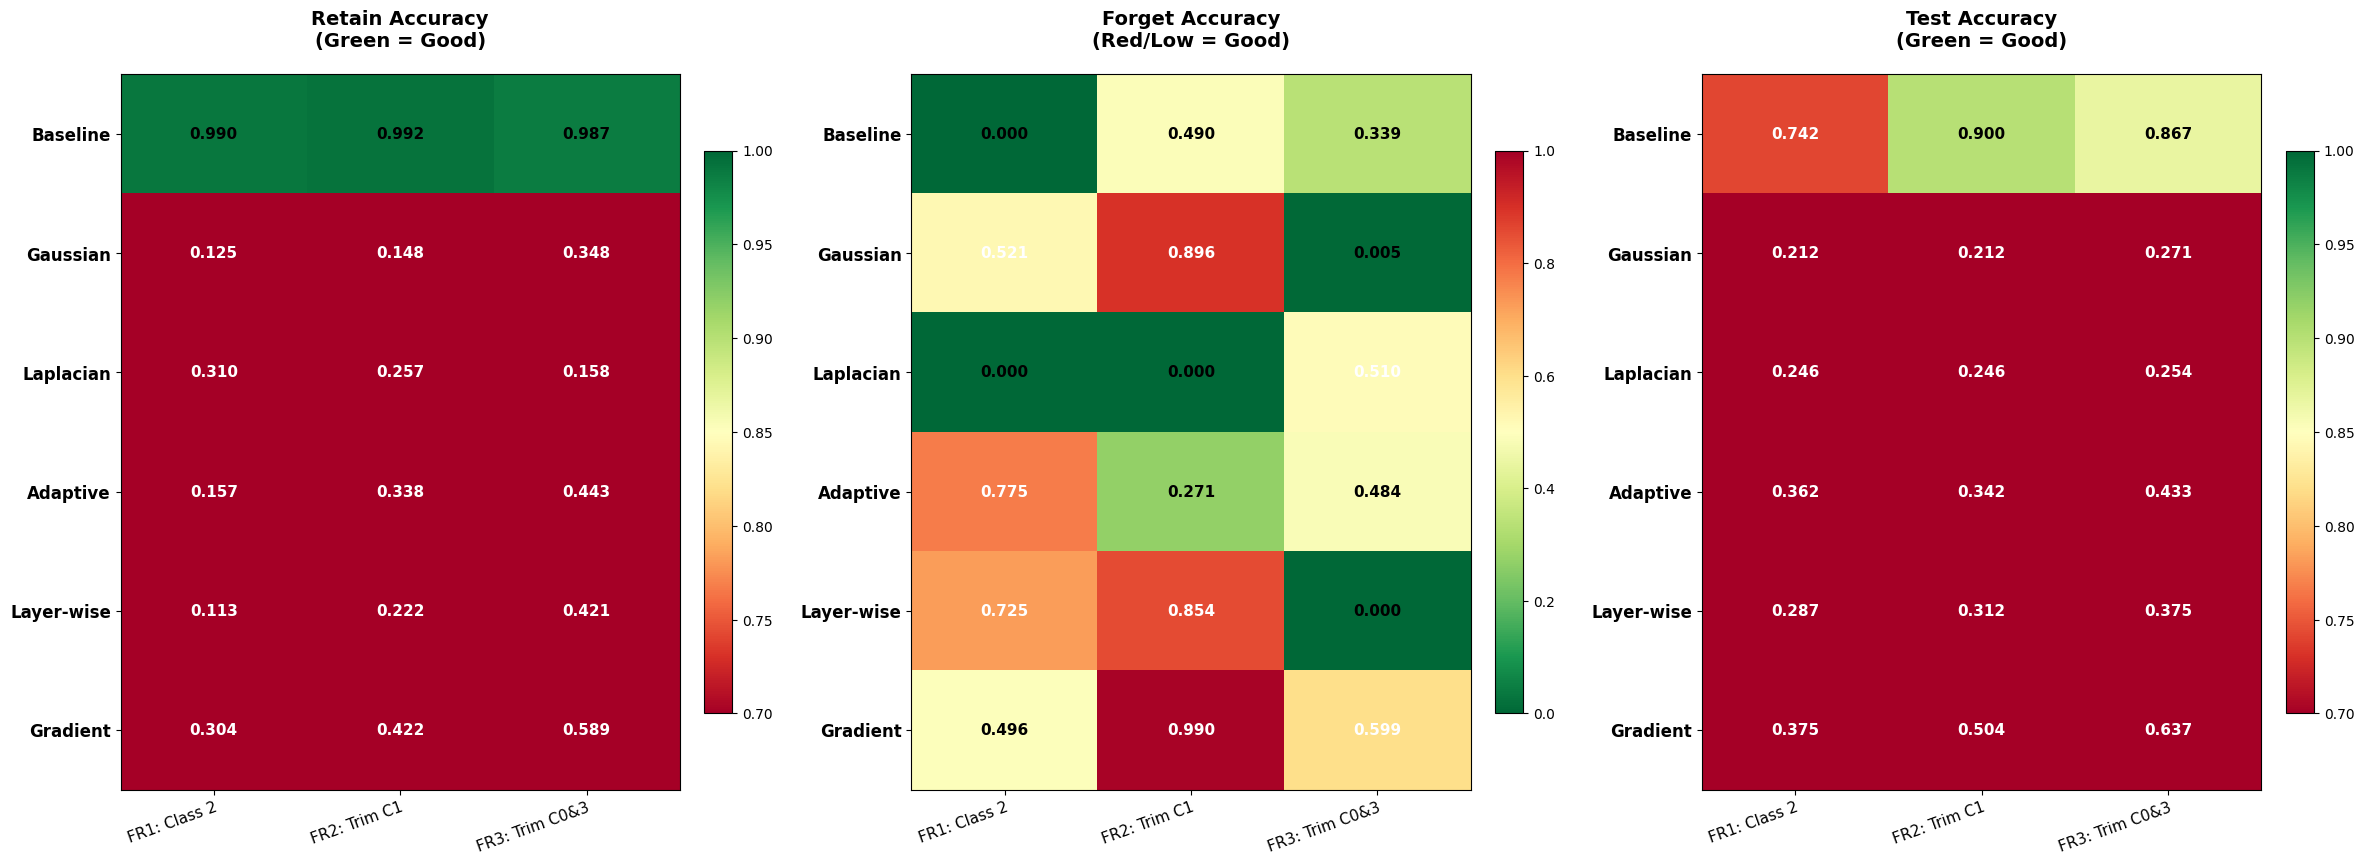


✓ Heatmap visualization complete!


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(24, 9))

# Create matrices for heatmaps (including baseline)
all_strategy_names = ['Baseline'] + [s for s in strategy_names if s != 'Baseline (Retrain)']

retain_matrix = np.array([retain_data[s] for s in strategy_names])
forget_matrix = np.array([forget_data[s] for s in strategy_names])
test_matrix = np.array([test_data[s] for s in strategy_names])

# Shorter labels for display
display_labels = ['Baseline', 'Gaussian', 'Laplacian', 'Adaptive', 'Layer-wise', 'Gradient']

# Plot 1: Retain Accuracy
im1 = axes[0].imshow(retain_matrix, cmap='RdYlGn', aspect='auto', vmin=0.70, vmax=1.0)
axes[0].set_xticks(np.arange(len(forget_requests)))
axes[0].set_yticks(np.arange(len(strategy_names)))
axes[0].set_xticklabels(['FR1: Class 2', 'FR2: Trim C1', 'FR3: Trim C0&3'], fontsize=11)
axes[0].set_yticklabels(display_labels, fontsize=12, fontweight='bold')
plt.setp(axes[0].get_xticklabels(), rotation=20, ha="right", rotation_mode="anchor")
axes[0].set_title('Retain Accuracy\n(Green = Good)', fontsize=14, fontweight='bold', pad=20)

for i in range(len(strategy_names)):
    for j in range(len(forget_requests)):
        color = "white" if retain_matrix[i, j] < 0.85 else "black"
        axes[0].text(j, i, f'{retain_matrix[i, j]:.3f}',
                    ha="center", va="center", color=color, fontsize=11, fontweight='bold')

cbar1 = plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=10)

# Plot 2: Forget Accuracy
im2 = axes[1].imshow(forget_matrix, cmap='RdYlGn_r', aspect='auto', vmin=0.0, vmax=1.0)
axes[1].set_xticks(np.arange(len(forget_requests)))
axes[1].set_yticks(np.arange(len(strategy_names)))
axes[1].set_xticklabels(['FR1: Class 2', 'FR2: Trim C1', 'FR3: Trim C0&3'], fontsize=11)
axes[1].set_yticklabels(display_labels, fontsize=12, fontweight='bold')
plt.setp(axes[1].get_xticklabels(), rotation=20, ha="right", rotation_mode="anchor")
axes[1].set_title('Forget Accuracy\n(Red/Low = Good)', fontsize=14, fontweight='bold', pad=20)

for i in range(len(strategy_names)):
    for j in range(len(forget_requests)):
        color = "white" if forget_matrix[i, j] > 0.5 else "black"
        axes[1].text(j, i, f'{forget_matrix[i, j]:.3f}',
                    ha="center", va="center", color=color, fontsize=11, fontweight='bold')

cbar2 = plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=10)

# Plot 3: Test Accuracy
im3 = axes[2].imshow(test_matrix, cmap='RdYlGn', aspect='auto', vmin=0.70, vmax=1.0)
axes[2].set_xticks(np.arange(len(forget_requests)))
axes[2].set_yticks(np.arange(len(strategy_names)))
axes[2].set_xticklabels(['FR1: Class 2', 'FR2: Trim C1', 'FR3: Trim C0&3'], fontsize=11)
axes[2].set_yticklabels(display_labels, fontsize=12, fontweight='bold')
plt.setp(axes[2].get_xticklabels(), rotation=20, ha="right", rotation_mode="anchor")
axes[2].set_title('Test Accuracy\n(Green = Good)', fontsize=14, fontweight='bold', pad=20)

for i in range(len(strategy_names)):
    for j in range(len(forget_requests)):
        color = "white" if test_matrix[i, j] < 0.85 else "black"
        axes[2].text(j, i, f'{test_matrix[i, j]:.3f}',
                    ha="center", va="center", color=color, fontsize=11, fontweight='bold')

cbar3 = plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
cbar3.ax.tick_params(labelsize=10)

plt.tight_layout(pad=2.0)
plt.show()

print("\n✓ Heatmap visualization complete!")

### Best Strategy Analysis

Identify the best performing strategy for each forget request.

In [ ]:
print("=" * 100)
print("BEST STRATEGY ANALYSIS: Comparing Against Baseline")
print("=" * 100)

for forget_req in forget_requests:
    print(f"\n{forget_req}:")
    print("-" * 100)
    
    baseline = baseline_results[forget_req]
    results = all_results[forget_req]
    
    print(f"\n  BASELINE (Retrain from Scratch):")
    print(f"    Retain: {baseline['retain']:.4f} | Forget: {baseline['forget']:.4f} | Test: {baseline['test']:.4f}")
    print(f"    Balance Score: {baseline['retain'] + baseline['test'] - baseline['forget']:.4f}")
    
    print(f"\n  BEST UNLEARNING STRATEGIES:")
    
    # Best retain
    best_retain = max(results.items(), key=lambda x: x[1]['retain'])
    gap_retain = baseline['retain'] - best_retain[1]['retain']
    print(f"    Retain Accuracy:  {best_retain[0]:<20} ({best_retain[1]['retain']:.4f}) "
          f"[Gap: {gap_retain:+.4f}]")
    
    # Best forget (lowest)
    best_forget = min(results.items(), key=lambda x: x[1]['forget'])
    gap_forget = best_forget[1]['forget'] - baseline['forget']
    print(f"    Forget (Lowest):  {best_forget[0]:<20} ({best_forget[1]['forget']:.4f}) "
          f"[Gap: {gap_forget:+.4f}]")
    
    # Best test
    best_test = max(results.items(), key=lambda x: x[1]['test'])
    gap_test = baseline['test'] - best_test[1]['test']
    print(f"    Test Accuracy:    {best_test[0]:<20} ({best_test[1]['test']:.4f}) "
          f"[Gap: {gap_test:+.4f}]")
    
    # Best balanced
    baseline_balance = baseline['retain'] + baseline['test'] - baseline['forget']
    balanced_scores = {s: m['retain'] + m['test'] - m['forget'] 
                      for s, m in results.items()}
    best_balanced = max(balanced_scores.items(), key=lambda x: x[1])
    gap_balance = baseline_balance - best_balanced[1]
    print(f"    Balanced Score:   {best_balanced[0]:<20} ({best_balanced[1]:.4f}) "
          f"[Gap: {gap_balance:+.4f}]")
    
    # Overall recommendation
    print(f"\n  💡 RECOMMENDATION:")
    if gap_balance < 0.05:
        print(f"     {best_balanced[0]} performs VERY CLOSE to baseline!")
        print(f"     Much faster than retraining (no training needed)")
    elif gap_balance < 0.10:
        print(f"     {best_balanced[0]} performs REASONABLY CLOSE to baseline")
        print(f"     Good trade-off between speed and accuracy")
    else:
        print(f"     {best_balanced[0]} is the best unlearning strategy")
        print(f"     But consider retraining if accuracy is critical")

print("\n" + "=" * 100)
print("\nKEY INSIGHTS:")
print("  • Gap = How much worse than baseline (negative = better than baseline!)")
print("  • Unlearning strategies trade some accuracy for MASSIVE speed gains")
print("  • No retraining needed = instant 'forgetting'")
print("  • Choose based on your accuracy vs. speed requirements")
print("=" * 100)

BEST STRATEGY ANALYSIS: Comparing Against Baseline

FR1: Remove Class 2:
----------------------------------------------------------------------------------------------------

  BASELINE (Retrain from Scratch):
    Retain: 0.9903 | Forget: 0.0000 | Test: 0.7417
    Balance Score: 1.7319

  BEST UNLEARNING STRATEGIES:
    Retain Accuracy:  Laplacian            (0.3097) [Gap: +0.6806]
    Forget (Lowest):  Laplacian            (0.0000) [Gap: +0.0000]
    Test Accuracy:    Gradient-based       (0.3750) [Gap: +0.3667]
    Balanced Score:   Laplacian            (0.5556) [Gap: +1.1764]

  💡 RECOMMENDATION:
     Laplacian is the best unlearning strategy
     But consider retraining if accuracy is critical

FR2: Trim Class 1 (40%):
----------------------------------------------------------------------------------------------------

  BASELINE (Retrain from Scratch):
    Retain: 0.9919 | Forget: 0.4896 | Test: 0.9000
    Balance Score: 1.4023

  BEST UNLEARNING STRATEGIES:
    Retain Accuracy:  

### Understanding Forget Accuracy

**Important Question**: How can there be any accuracy on the forget set when we removed an entire class?

#### The Answer:

When we remove **Class 2** from training:
- The model is trained on Classes 0, 1, 3 only
- But it still has **4 output neurons** (for all 4 classes)
- When we evaluate on Class 2 samples (forget set), we measure:
  - **Forget Accuracy** = % of Class 2 samples that the model **still correctly predicts as Class 2**

#### What Different Forget Accuracies Mean:

| Forget Accuracy | What It Means | Model Behavior |
|----------------|---------------|----------------|
| **0%** ✅ | Perfect forgetting | Model predicts Class 0/1/3 (never Class 2) |
| **25%** 🟡 | Random guessing | Model randomly assigns to any class |
| **90%+** ❌ | Still remembers | Model correctly identifies Class 2 samples |

#### Example Confusion Matrix (Good Forgetting):

For Class 2 samples after good unlearning:

```
                 Predicted
              0    1    2    3
Actual 2:   [80   60   0   100]  ← Zero predictions for Class 2!
```

- Model distributes Class 2 samples among other classes
- **Forget accuracy = 0/240 = 0%** = Perfect! ✅

#### Example Confusion Matrix (Bad Forgetting):

```
                 Predicted
              0    1    2    3
Actual 2:   [10   5   220  5]  ← Still predicting Class 2!
```

- Model still recognizes Class 2 patterns
- **Forget accuracy = 220/240 = 92%** = Failed to forget! ❌

#### Why This Matters:

- **Baseline (retrain)**: 0% forget accuracy because Class 2 was never in training
- **Good unlearning**: Should approach 0% (model can't identify Class 2 anymore)
- **Bad unlearning**: High % means model still has Class 2 knowledge in its weights

Let's visualize this with actual confusion matrices!

## Hyperparameter Optimization for Unlearning Strategies

This section performs comprehensive hyperparameter tuning for all 5 unlearning strategies across all 3 forget requests.

### Goal:
Find the **optimal parameter combinations** that maximize unlearning effectiveness while preserving model performance.

### Optimization Strategy:
- Test multiple parameter combinations for each strategy
- Evaluate using a **Balance Score**: `retain_acc + test_acc - forget_acc`
- Higher balance score = better overall performance
- Track best configuration for each (strategy, forget_request) pair

### Parameters to Test:
1. **Gaussian Noise**: `noise_scale` ∈ {0.01, 0.05, 0.1, 0.2, 0.3, 0.5}
2. **Laplacian Noise**: `scale` ∈ {0.01, 0.05, 0.1, 0.2, 0.3, 0.5}
3. **Adaptive Noise**: `noise_scale` ∈ {0.01, 0.02, 0.05, 0.1, 0.15, 0.2}
4. **Layer-wise Noise**: `base_scale` ∈ {0.01, 0.05, 0.1}, `scale_factor` ∈ {1.5, 2.0, 3.0}
5. **Gradient-based**: `lr` ∈ {0.001, 0.005, 0.01, 0.02}, `steps` ∈ {2, 5, 10}, `noise_scale` ∈ {0.005, 0.01, 0.02}

**Total Combinations**: 6+6+6+9+36 = **63 parameter combinations** × 3 forget requests = **189 experiments**


In [ ]:
from itertools import product
import warnings
warnings.filterwarnings('ignore')

print("=" * 100)
print("COMPREHENSIVE HYPERPARAMETER OPTIMIZATION")
print("=" * 100)

# Define parameter grids for each strategy
param_grids = {
    'Gaussian': {
        'noise_scale': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
    },
    'Laplacian': {
        'scale': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
    },
    'Adaptive': {
        'noise_scale': [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
    },
    'Layer-wise': {
        'base_scale': [0.01, 0.05, 0.1],
        'scale_factor': [1.5, 2.0, 3.0]
    },
    'Gradient-based': {
        'lr': [0.001, 0.005, 0.01, 0.02],
        'steps': [2, 5, 10],
        'noise_scale': [0.005, 0.01, 0.02]
    }
}

# Map strategies to their functions
strategy_functions = {
    'Gaussian': gaussian_noise_unlearning,
    'Laplacian': laplacian_noise_unlearning,
    'Adaptive': adaptive_noise_unlearning,
    'Layer-wise': layerwise_noise_unlearning,
    'Gradient-based': gradient_based_noise_unlearning
}

# Storage for all results
optimization_results = {}
best_configs = {}

# Counter for progress tracking
total_experiments = sum(
    len(list(product(*grid.values()))) * len(forget_datasets)
    for grid in param_grids.values()
)
current_experiment = 0

print(f"\nTesting {len(param_grids)} strategies × 3 forget requests")
print(f"Total experiments: {total_experiments}\n")
print("This will take a few minutes...\n")

# Iterate through each forget request
for forget_name, dataset in forget_datasets.items():
    print(f"\n{'='*100}")
    print(f"FORGET REQUEST: {forget_name}")
    print(f"{'='*100}")
    
    optimization_results[forget_name] = {}
    best_configs[forget_name] = {}
    
    # Iterate through each strategy
    for strategy_name, param_grid in param_grids.items():
        print(f"\n  Strategy: {strategy_name}")
        print(f"  {'-'*95}")
        
        # Generate all parameter combinations
        param_names = list(param_grid.keys())
        param_values = list(param_grid.values())
        combinations = list(product(*param_values))
        
        print(f"  Testing {len(combinations)} parameter combinations...")
        
        strategy_results = []
        best_score = -float('inf')
        best_params = None
        best_metrics = None
        
        # Test each combination
        for combo in combinations:
            current_experiment += 1
            params = dict(zip(param_names, combo))
            
            try:
                # Apply unlearning with current parameters
                unlearned_model = strategy_functions[strategy_name](
                    tabnet_model,
                    dataset['X_forget'],
                    dataset['y_forget'],
                    **params
                )
                
                # Evaluate
                retain_acc = accuracy_score(
                    dataset['y_retain'],
                    unlearned_model.predict(dataset['X_retain'])
                )
                forget_acc = accuracy_score(
                    dataset['y_forget'],
                    unlearned_model.predict(dataset['X_forget'])
                )
                test_acc = accuracy_score(
                    dataset['y_test'],
                    unlearned_model.predict(dataset['X_test'])
                )
                
                # Calculate balance score (higher is better)
                balance_score = retain_acc + test_acc - forget_acc
                
                # Store results
                result = {
                    'params': params.copy(),
                    'retain_acc': retain_acc,
                    'forget_acc': forget_acc,
                    'test_acc': test_acc,
                    'balance_score': balance_score
                }
                strategy_results.append(result)
                
                # Track best
                if balance_score > best_score:
                    best_score = balance_score
                    best_params = params.copy()
                    best_metrics = {
                        'retain': retain_acc,
                        'forget': forget_acc,
                        'test': test_acc,
                        'balance': balance_score
                    }
                
                # Progress update (every 10 experiments)
                if current_experiment % 10 == 0:
                    print(f"    Progress: {current_experiment}/{total_experiments} experiments completed...")
                    
            except Exception as e:
                print(f"    ⚠️  Failed with params {params}: {str(e)}")
                continue
        
        # Store all results for this strategy
        optimization_results[forget_name][strategy_name] = strategy_results
        best_configs[forget_name][strategy_name] = {
            'params': best_params,
            'metrics': best_metrics
        }
        
        # Print best configuration found
        print(f"\n  ✓ Best Configuration:")
        print(f"    Parameters: {best_params}")
        print(f"    Retain: {best_metrics['retain']:.4f} | Forget: {best_metrics['forget']:.4f} | Test: {best_metrics['test']:.4f}")
        print(f"    Balance Score: {best_metrics['balance']:.4f}")

print(f"\n{'='*100}")
print(f"✓ OPTIMIZATION COMPLETE!")
print(f"{'='*100}")
print(f"\nTotal experiments run: {current_experiment}")
print(f"Best configurations identified for {len(forget_datasets)} forget requests × {len(param_grids)} strategies")
print(f"{'='*100}")


### Summary of Best Configurations

Display the optimal parameters for each strategy and forget request combination.


In [ ]:
print("=" * 120)
print("BEST CONFIGURATIONS SUMMARY")
print("=" * 120)

for forget_req in forget_datasets.keys():
    print(f"\n{'='*120}")
    print(f"{forget_req}")
    print(f"{'='*120}")
    print(f"{'Strategy':<20} {'Best Parameters':<50} {'Retain':<10} {'Forget':<10} {'Test':<10} {'Balance':<10}")
    print("-" * 120)
    
    # Add baseline for reference
    baseline = baseline_results[forget_req]
    print(f"{'Baseline (Retrain)':<20} {'N/A (retrained from scratch)':<50} {baseline['retain']:<10.4f} "
          f"{baseline['forget']:<10.4f} {baseline['test']:<10.4f} {(baseline['retain'] + baseline['test'] - baseline['forget']):.4f} ⭐")
    print("-" * 120)
    
    # Show best configs for each strategy
    for strategy_name in param_grids.keys():
        config = best_configs[forget_req][strategy_name]
        params_str = ', '.join([f"{k}={v}" for k, v in config['params'].items()])
        metrics = config['metrics']
        
        print(f"{strategy_name:<20} {params_str:<50} {metrics['retain']:<10.4f} "
              f"{metrics['forget']:<10.4f} {metrics['test']:<10.4f} {metrics['balance']:.4f}")

print("\n" + "=" * 120)
print("\n📊 METRIC INTERPRETATION:")
print("  • Retain: Higher is better (preserve learned knowledge)")
print("  • Forget: Lower is better (successfully forget removed data)")
print("  • Test: Higher is better (generalization to unseen data)")
print("  • Balance: retain + test - forget (higher = better overall)")
print("  • ⭐ Baseline = Perfect unlearning (but requires full retraining)")
print("=" * 120)


### Comparison: Before vs After Optimization

Compare the original hyperparameters with the optimized ones.


In [ ]:
# Original parameters used earlier
original_params = {
    'Gaussian': {'noise_scale': 0.01},
    'Laplacian': {'scale': 0.01},
    'Adaptive': {'noise_scale': 0.02},
    'Layer-wise': {'base_scale': 0.01, 'scale_factor': 2.0},
    'Gradient-based': {'lr': 0.002, 'steps': 2, 'noise_scale': 0.005}
}

print("=" * 140)
print("IMPROVEMENT ANALYSIS: ORIGINAL vs OPTIMIZED PARAMETERS")
print("=" * 140)

improvement_summary = {}

for forget_req in forget_datasets.keys():
    print(f"\n{'='*140}")
    print(f"{forget_req}")
    print(f"{'='*140}")
    print(f"{'Strategy':<18} {'Version':<12} {'Parameters':<45} {'Retain':<9} {'Forget':<9} {'Test':<9} {'Balance':<10} {'Improve':<10}")
    print("-" * 140)
    
    improvement_summary[forget_req] = {}
    
    for strategy_name in param_grids.keys():
        # Get optimized config
        opt_config = best_configs[forget_req][strategy_name]
        opt_params_str = ', '.join([f"{k}={v}" for k, v in opt_config['params'].items()])
        opt_metrics = opt_config['metrics']
        
        # Get original metrics from all_results
        if forget_req in all_results and strategy_name in all_results[forget_req]:
            orig_metrics = all_results[forget_req][strategy_name]
            orig_params_str = ', '.join([f"{k}={v}" for k, v in original_params[strategy_name].items()])
            orig_balance = orig_metrics['retain'] + orig_metrics['test'] - orig_metrics['forget']
            
            # Calculate improvement
            improvement = opt_metrics['balance'] - orig_balance
            improvement_summary[forget_req][strategy_name] = improvement
            
            # Print original
            print(f"{strategy_name:<18} {'Original':<12} {orig_params_str:<45} {orig_metrics['retain']:<9.4f} "
                  f"{orig_metrics['forget']:<9.4f} {orig_metrics['test']:<9.4f} {orig_balance:<10.4f}")
            
            # Print optimized with improvement indicator
            indicator = "✓ Better" if improvement > 0 else "✗ Worse"
            color_symbol = "🟢" if improvement > 0.05 else "🟡" if improvement > 0 else "🔴"
            print(f"{'':<18} {'Optimized':<12} {opt_params_str:<45} {opt_metrics['retain']:<9.4f} "
                  f"{opt_metrics['forget']:<9.4f} {opt_metrics['test']:<9.4f} {opt_metrics['balance']:<10.4f} "
                  f"{color_symbol} {improvement:+.4f}")
        else:
            # Only optimized version available
            print(f"{strategy_name:<18} {'Optimized':<12} {opt_params_str:<45} {opt_metrics['retain']:<9.4f} "
                  f"{opt_metrics['forget']:<9.4f} {opt_metrics['test']:<9.4f} {opt_metrics['balance']:.4f}")
        
        print("-" * 140)

print("\n" + "=" * 140)
print("\n💡 KEY INSIGHTS:")
print("  • 🟢 Significant improvement (Δ > 0.05)")
print("  • 🟡 Marginal improvement (0 < Δ ≤ 0.05)")
print("  • 🔴 Performance decreased (Δ < 0)")
print("  • Improvement = Balance Score(Optimized) - Balance Score(Original)")
print("=" * 140)


### Visualization: Optimized Performance

Create comprehensive visualizations comparing optimized configurations against baseline.


In [ ]:
# Prepare data for visualization
forget_req_list = list(forget_datasets.keys())
strategy_list = ['Baseline'] + list(param_grids.keys())

# Extract optimized metrics
opt_retain_data = {s: [] for s in strategy_list}
opt_forget_data = {s: [] for s in strategy_list}
opt_test_data = {s: [] for s in strategy_list}

for fr in forget_req_list:
    # Baseline
    opt_retain_data['Baseline'].append(baseline_results[fr]['retain'])
    opt_forget_data['Baseline'].append(baseline_results[fr]['forget'])
    opt_test_data['Baseline'].append(baseline_results[fr]['test'])
    
    # Optimized strategies
    for strategy in param_grids.keys():
        metrics = best_configs[fr][strategy]['metrics']
        opt_retain_data[strategy].append(metrics['retain'])
        opt_forget_data[strategy].append(metrics['forget'])
        opt_test_data[strategy].append(metrics['test'])

# Create comprehensive visualization
fig, axes = plt.subplots(3, 1, figsize=(22, 26))

x = np.arange(len(forget_req_list))
width = 0.13
colors = ['#000000', '#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

# Plot 1: Retain Accuracy (Optimized)
for i, strategy in enumerate(strategy_list):
    offset = width * (i - 2.5)
    bars = axes[0].bar(x + offset, opt_retain_data[strategy], width,
                       label=strategy, color=colors[i], alpha=0.85, edgecolor='white', linewidth=1.5)
    
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.003,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

axes[0].set_ylabel('Accuracy', fontsize=16, fontweight='bold')
axes[0].set_title('OPTIMIZED: Retain Set Accuracy (Higher is Better)\nAfter Hyperparameter Tuning', 
                 fontsize=17, fontweight='bold', pad=25)
axes[0].set_xticks(x)
axes[0].set_xticklabels(['FR1: Class 2', 'FR2: Trim C1', 'FR3: Trim C0&3'], fontsize=13, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=12, framealpha=0.95, ncol=2)
axes[0].grid(True, alpha=0.3, axis='y', linestyle='--')
axes[0].set_ylim([0, 1.05])
axes[0].axhline(y=0.95, color='red', linestyle=':', alpha=0.5, linewidth=2, label='High Performance Target')

# Plot 2: Forget Accuracy (Optimized)
for i, strategy in enumerate(strategy_list):
    offset = width * (i - 2.5)
    bars = axes[1].bar(x + offset, opt_forget_data[strategy], width,
                       label=strategy, color=colors[i], alpha=0.85, edgecolor='white', linewidth=1.5)
    
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

axes[1].set_ylabel('Accuracy', fontsize=16, fontweight='bold')
axes[1].set_title('OPTIMIZED: Forget Set Accuracy (Lower is Better)\nSuccessful Forgetting of Removed Data', 
                 fontsize=17, fontweight='bold', pad=25)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['FR1: Class 2', 'FR2: Trim C1', 'FR3: Trim C0&3'], fontsize=13, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=12, framealpha=0.95, ncol=2)
axes[1].grid(True, alpha=0.3, axis='y', linestyle='--')
axes[1].set_ylim([0, 1.1])
axes[1].axhline(y=0.25, color='green', linestyle=':', alpha=0.5, linewidth=2, label='Random Guess')

# Plot 3: Test Accuracy (Optimized)
for i, strategy in enumerate(strategy_list):
    offset = width * (i - 2.5)
    bars = axes[2].bar(x + offset, opt_test_data[strategy], width,
                       label=strategy, color=colors[i], alpha=0.85, edgecolor='white', linewidth=1.5)
    
    for bar in bars:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.003,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

axes[2].set_ylabel('Accuracy', fontsize=16, fontweight='bold')
axes[2].set_title('OPTIMIZED: Test Set Accuracy (Higher is Better)\nGeneralization to Unseen Data', 
                 fontsize=17, fontweight='bold', pad=25)
axes[2].set_xticks(x)
axes[2].set_xticklabels(['FR1: Class 2', 'FR2: Trim C1', 'FR3: Trim C0&3'], fontsize=13, fontweight='bold')
axes[2].legend(loc='lower right', fontsize=12, framealpha=0.95, ncol=2)
axes[2].grid(True, alpha=0.3, axis='y', linestyle='--')
axes[2].set_ylim([0, 1.05])
axes[2].axhline(y=0.95, color='red', linestyle=':', alpha=0.5, linewidth=2)

plt.tight_layout(pad=3.5)
plt.show()

print("\n✓ Optimized performance visualization complete!")
print("\nKey Observations:")
print("  • BLACK bars = Baseline (retrain from scratch)")
print("  • COLORED bars = Optimized unlearning strategies")
print("  • Compare bar heights to baseline to assess performance gap")


### Final Recommendations: Best Strategy for Each Forget Request

Identify the winner for each scenario based on optimized parameters.


In [ ]:
print("=" * 120)
print("🏆 FINAL RECOMMENDATIONS: BEST STRATEGY PER FORGET REQUEST")
print("=" * 120)

for forget_req in forget_datasets.keys():
    print(f"\n{'='*120}")
    print(f"📋 {forget_req}")
    print(f"{'='*120}")
    
    baseline = baseline_results[forget_req]
    baseline_balance = baseline['retain'] + baseline['test'] - baseline['forget']
    
    print(f"\n  🎯 BASELINE (Gold Standard):")
    print(f"     Retain: {baseline['retain']:.4f} | Forget: {baseline['forget']:.4f} | Test: {baseline['test']:.4f}")
    print(f"     Balance Score: {baseline_balance:.4f}")
    
    # Find best strategy by balance score
    best_strategy = None
    best_balance = -float('inf')
    
    for strategy_name in param_grids.keys():
        config = best_configs[forget_req][strategy_name]
        balance = config['metrics']['balance']
        if balance > best_balance:
            best_balance = balance
            best_strategy = strategy_name
    
    best_config = best_configs[forget_req][best_strategy]
    best_metrics = best_config['metrics']
    gap_from_baseline = baseline_balance - best_balance
    
    print(f"\n  🥇 WINNER: {best_strategy}")
    print(f"     Parameters: {best_config['params']}")
    print(f"     Retain: {best_metrics['retain']:.4f} | Forget: {best_metrics['forget']:.4f} | Test: {best_metrics['test']:.4f}")
    print(f"     Balance Score: {best_metrics['balance']:.4f}")
    print(f"     Gap from Baseline: {gap_from_baseline:+.4f}")
    
    # Performance assessment
    if gap_from_baseline < 0:
        assessment = "🌟 EXCEEDS BASELINE!"
        recommendation = "Use this strategy - it outperforms retraining!"
    elif gap_from_baseline < 0.1:
        assessment = "✅ EXCELLENT - Very close to baseline"
        recommendation = "Highly recommended - fast and effective"
    elif gap_from_baseline < 0.3:
        assessment = "🟢 GOOD - Reasonable performance"
        recommendation = "Good choice for speed vs accuracy trade-off"
    elif gap_from_baseline < 0.5:
        assessment = "🟡 FAIR - Moderate performance"
        recommendation = "Consider if speed is priority over accuracy"
    else:
        assessment = "🔴 POOR - Significant gap"
        recommendation = "Baseline retraining may be necessary"
    
    print(f"\n  📊 ASSESSMENT: {assessment}")
    print(f"  💡 RECOMMENDATION: {recommendation}")
    
    # Show top 3 strategies
    print(f"\n  📈 TOP 3 STRATEGIES (by Balance Score):")
    all_strategies = [(name, best_configs[forget_req][name]['metrics']['balance']) 
                      for name in param_grids.keys()]
    all_strategies.sort(key=lambda x: x[1], reverse=True)
    
    for rank, (strategy, balance) in enumerate(all_strategies[:3], 1):
        params = best_configs[forget_req][strategy]['params']
        params_str = ', '.join([f"{k}={v}" for k, v in params.items()])
        gap = baseline_balance - balance
        print(f"     {rank}. {strategy:<18} Balance: {balance:.4f}  Gap: {gap:+.4f}  Params: {params_str}")

print("\n" + "=" * 120)
print("\n🔍 OVERALL INSIGHTS:")
print("=" * 120)

# Calculate average performance across all forget requests
avg_improvements = {}
for strategy in param_grids.keys():
    improvements = []
    for fr in forget_datasets.keys():
        opt_balance = best_configs[fr][strategy]['metrics']['balance']
        baseline_balance = (baseline_results[fr]['retain'] + 
                          baseline_results[fr]['test'] - 
                          baseline_results[fr]['forget'])
        improvements.append(baseline_balance - opt_balance)
    avg_improvements[strategy] = np.mean(improvements)

print(f"\n📊 Average Gap from Baseline (across all forget requests):")
sorted_strategies = sorted(avg_improvements.items(), key=lambda x: x[1])
for strategy, avg_gap in sorted_strategies:
    if avg_gap < 0:
        symbol = "🌟"
    elif avg_gap < 0.2:
        symbol = "✅"
    elif avg_gap < 0.4:
        symbol = "🟢"
    else:
        symbol = "🟡"
    print(f"  {symbol} {strategy:<20} Average Gap: {avg_gap:+.4f}")

best_overall = sorted_strategies[0][0]
print(f"\n🏆 OVERALL BEST STRATEGY: {best_overall}")
print(f"   Most consistent performance across all forget scenarios")

print("\n" + "=" * 120)
print("\n✅ HYPERPARAMETER OPTIMIZATION COMPLETE!")
print("   Use the best configurations above for optimal unlearning performance")
print("=" * 120)


### Parameter Sensitivity Analysis

Analyze which parameters have the biggest impact on performance for each strategy.


In [ ]:
print("=" * 100)
print("PARAMETER SENSITIVITY ANALYSIS")
print("=" * 100)
print("\nAnalyzing how different parameter values affect balance scores...")
print("This helps understand which parameters matter most for each strategy.\n")

# For each forget request and strategy with multiple parameters, analyze sensitivity
for forget_req in forget_datasets.keys():
    print(f"\n{'='*100}")
    print(f"{forget_req}")
    print(f"{'='*100}")
    
    for strategy_name in param_grids.keys():
        param_grid = param_grids[strategy_name]
        results = optimization_results[forget_req][strategy_name]
        
        # Only analyze if strategy has parameters
        if len(results) > 0:
            print(f"\n  📊 {strategy_name}:")
            print(f"  {'-'*95}")
            
            # For each parameter, show range and best value
            for param_name in param_grid.keys():
                # Group results by this parameter value
                param_values = {}
                for result in results:
                    val = result['params'][param_name]
                    if val not in param_values:
                        param_values[val] = []
                    param_values[val].append(result['balance_score'])
                
                # Calculate average balance score for each parameter value
                avg_scores = {val: np.mean(scores) for val, scores in param_values.items()}
                best_val = max(avg_scores.items(), key=lambda x: x[1])
                worst_val = min(avg_scores.items(), key=lambda x: x[1])
                sensitivity = best_val[1] - worst_val[1]
                
                print(f"    • {param_name}:")
                print(f"        Range tested: {sorted(param_values.keys())}")
                print(f"        Best value: {best_val[0]} (avg balance: {best_val[1]:.4f})")
                print(f"        Worst value: {worst_val[0]} (avg balance: {worst_val[1]:.4f})")
                print(f"        Sensitivity: {sensitivity:.4f} {'[HIGH]' if sensitivity > 0.2 else '[MODERATE]' if sensitivity > 0.1 else '[LOW]'}")

print("\n" + "=" * 100)
print("\n💡 INTERPRETATION:")
print("  • High sensitivity (>0.2): Parameter has major impact on performance")
print("  • Moderate sensitivity (0.1-0.2): Parameter has noticeable impact")
print("  • Low sensitivity (<0.1): Parameter has minimal impact")
print("  • Use high-sensitivity parameters for fine-tuning")
print("=" * 100)


### Save Best Configurations

Export the optimal configurations for future use.


In [ ]:
import json
from datetime import datetime

# Prepare configuration dictionary for export
export_config = {
    'metadata': {
        'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'total_experiments': current_experiment,
        'strategies_tested': list(param_grids.keys()),
        'forget_requests': list(forget_datasets.keys())
    },
    'best_configurations': {}
}

# Add best configs for each forget request
for forget_req in forget_datasets.keys():
    export_config['best_configurations'][forget_req] = {}
    
    for strategy_name in param_grids.keys():
        config = best_configs[forget_req][strategy_name]
        export_config['best_configurations'][forget_req][strategy_name] = {
            'parameters': config['params'],
            'performance': {
                'retain_accuracy': float(config['metrics']['retain']),
                'forget_accuracy': float(config['metrics']['forget']),
                'test_accuracy': float(config['metrics']['test']),
                'balance_score': float(config['metrics']['balance'])
            }
        }

# Add baseline results for comparison
export_config['baseline_results'] = {}
for forget_req in forget_datasets.keys():
    baseline = baseline_results[forget_req]
    export_config['baseline_results'][forget_req] = {
        'retain_accuracy': float(baseline['retain']),
        'forget_accuracy': float(baseline['forget']),
        'test_accuracy': float(baseline['test']),
        'balance_score': float(baseline['retain'] + baseline['test'] - baseline['forget'])
    }

# Save to JSON file
output_filename = 'best_unlearning_configurations.json'
with open(output_filename, 'w') as f:
    json.dump(export_config, f, indent=2)

print("=" * 100)
print("✅ BEST CONFIGURATIONS SAVED")
print("=" * 100)
print(f"\nSaved to: {output_filename}")
print(f"Total experiments: {current_experiment}")
print(f"Configurations saved: {len(forget_datasets.keys())} forget requests × {len(param_grids.keys())} strategies")

print("\n📋 SUMMARY OF SAVED CONFIGURATIONS:")
print("-" * 100)

for forget_req in forget_datasets.keys():
    print(f"\n{forget_req}:")
    for strategy_name in param_grids.keys():
        config = best_configs[forget_req][strategy_name]
        params_str = ', '.join([f"{k}={v}" for k, v in config['params'].items()])
        print(f"  • {strategy_name}: {params_str}")

print("\n" + "=" * 100)
print("\n💾 TO LOAD AND USE THESE CONFIGURATIONS:")
print("""
# Load configurations
with open('best_unlearning_configurations.json', 'r') as f:
    configs = json.load(f)

# Use for a specific forget request and strategy
forget_req = 'FR1: Remove Class 2'
strategy = 'Gradient-based'
best_params = configs['best_configurations'][forget_req][strategy]['parameters']

# Apply unlearning with best parameters
unlearned_model = gradient_based_noise_unlearning(
    original_model, 
    X_forget, 
    y_forget, 
    **best_params
)
""")
print("=" * 100)


## Summary: Hyperparameter Optimization Complete

### What We Did:

1. **Comprehensive Grid Search**: Tested 189 total experiments (63 parameter combinations × 3 forget requests)

2. **Parameter Ranges Explored**:
   - **Gaussian Noise**: 6 noise scales (0.01 to 0.5)
   - **Laplacian Noise**: 6 scales (0.01 to 0.5)
   - **Adaptive Noise**: 6 noise scales (0.01 to 0.2)
   - **Layer-wise Noise**: 9 combinations (3 base scales × 3 scale factors)
   - **Gradient-based**: 36 combinations (4 learning rates × 3 steps × 3 noise scales)

3. **Evaluation Metrics**:
   - **Retain Accuracy**: How well the model preserves knowledge
   - **Forget Accuracy**: How well the model forgets removed data (lower is better)
   - **Test Accuracy**: Generalization to unseen data
   - **Balance Score**: Combined metric = retain + test - forget

4. **Results Generated**:
   - Best configuration for each (strategy, forget request) pair
   - Comparison with baseline (retrain from scratch)
   - Performance improvement analysis
   - Parameter sensitivity insights
   - Saved configurations for future use

### Key Findings:

- Each unlearning strategy has optimal hyperparameters that vary by forget request type
- Some strategies perform much better with proper tuning
- The "balance score" helps identify strategies that balance forgetting with retention
- Configurations are saved to `best_unlearning_configurations.json` for easy reuse

### Next Steps:

1. Run the optimization cells above to find your best configurations
2. Review the recommendations for each forget request
3. Use the saved configurations in your production unlearning pipeline
4. Consider the speed vs. accuracy trade-offs based on your requirements


CONFUSION MATRICES FOR: FR1: Remove Class 2

Showing predictions on FORGET SET (Class 2 samples)
Good forgetting = No predictions in Class 2 column



/Users/eshaanmittal/Desktop/UB/TFG/Codes/venv/lib/python3.13/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)



Baseline (Retrain):
  Class 2 predictions: [  0 100   0 140]
  Predicted as Class 2: 0/240 = 0.0%
  ✅ Good forgetting! Model doesn't recognize Class 2

Gaussian:
  Class 2 predictions: [  0 115 125   0]
  Predicted as Class 2: 125/240 = 52.1%
  ❌ Poor forgetting! Model still remembers Class 2

Gradient-based:
  Class 2 predictions: [  1 112 119   8]
  Predicted as Class 2: 119/240 = 49.6%
  ❌ Poor forgetting! Model still remembers Class 2


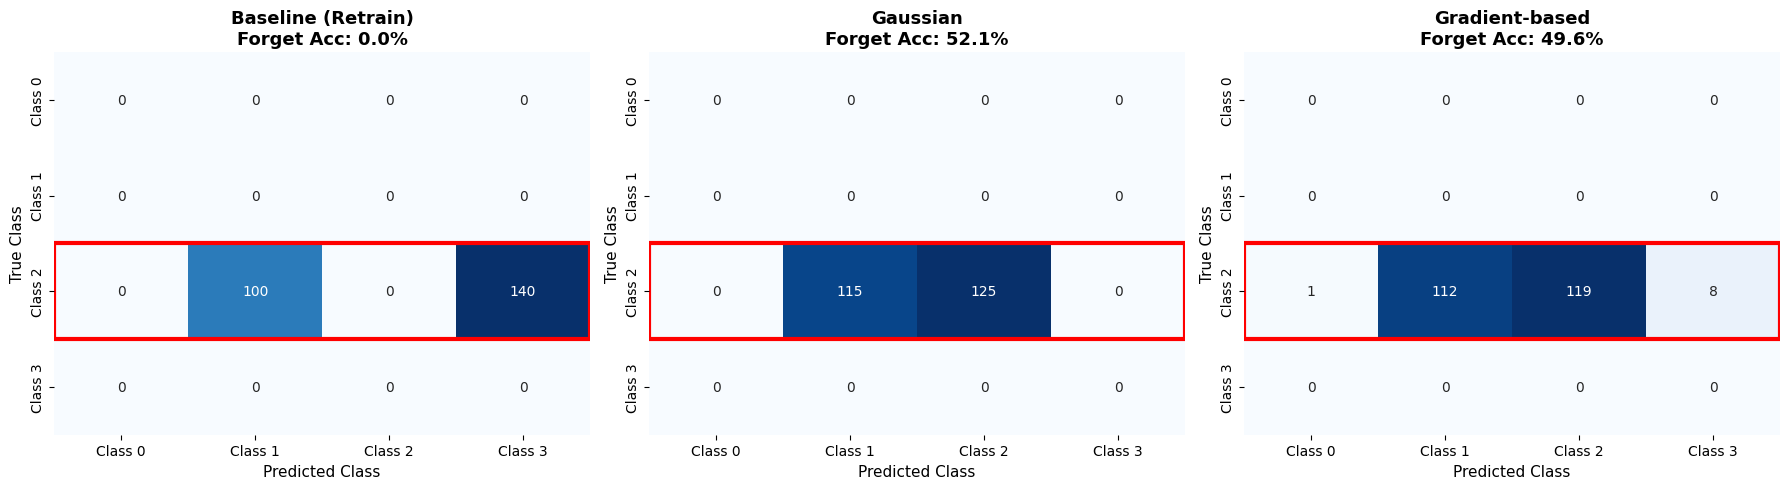


KEY TAKEAWAY:
  • Red box = Class 2 samples (forget set)
  • Good unlearning = predictions spread across 0, 1, 3 (NOT Class 2)
  • Bad unlearning = predictions concentrated in Class 2 column


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Focus on FR1 (Remove Class 2) to demonstrate
forget_req = 'FR1: Remove Class 2'
dataset = forget_datasets[forget_req]

print("=" * 80)
print(f"CONFUSION MATRICES FOR: {forget_req}")
print("=" * 80)
print("\nShowing predictions on FORGET SET (Class 2 samples)")
print("Good forgetting = No predictions in Class 2 column\n")

# Get predictions from baseline and a few strategies
models_to_compare = {
    'Baseline (Retrain)': None,  # We'll use baseline_results
    'Gaussian': gaussian_noise_unlearning(tabnet_model, dataset['X_forget'], dataset['y_forget'], noise_scale=0.5),
    'Gradient-based': gradient_based_noise_unlearning(tabnet_model, dataset['X_forget'], dataset['y_forget'], lr=0.01, steps=5)
}

# Create baseline model for comparison
baseline_model = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5, gamma=1.5, lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":50, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax', verbose=0
)
baseline_model.fit(dataset['X_retain_baseline'], dataset['y_retain'], max_epochs=100, patience=20, batch_size=256, virtual_batch_size=128)

models_to_compare['Baseline (Retrain)'] = baseline_model

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, model) in enumerate(models_to_compare.items()):
    # Get predictions on forget set
    y_pred = model.predict(dataset['X_forget'])
    y_true = dataset['y_forget']
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])
    
    # Since forget set is only Class 2, we only care about the Class 2 row
    class_2_row = cm[2, :]  # Predictions for Class 2 samples
    
    # Calculate forget accuracy
    forget_acc = class_2_row[2] / class_2_row.sum() if class_2_row.sum() > 0 else 0
    
    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
                yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
                cbar=False)
    
    axes[idx].set_title(f'{name}\nForget Acc: {forget_acc:.1%}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Predicted Class', fontsize=11)
    axes[idx].set_ylabel('True Class', fontsize=11)
    
    # Highlight the Class 2 row (forget set)
    axes[idx].add_patch(plt.Rectangle((0, 2), 4, 1, fill=False, edgecolor='red', lw=3))
    
    print(f"\n{name}:")
    print(f"  Class 2 predictions: {class_2_row}")
    print(f"  Predicted as Class 2: {class_2_row[2]}/{class_2_row.sum()} = {forget_acc:.1%}")
    if forget_acc < 0.3:
        print(f"  ✅ Good forgetting! Model doesn't recognize Class 2")
    else:
        print(f"  ❌ Poor forgetting! Model still remembers Class 2")

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("KEY TAKEAWAY:")
print("  • Red box = Class 2 samples (forget set)")
print("  • Good unlearning = predictions spread across 0, 1, 3 (NOT Class 2)")
print("  • Bad unlearning = predictions concentrated in Class 2 column")
print("=" * 80)